In [1]:
import xcesm
import numpy as np
import sacpy as scp
import xarray as xr
import pandas as pd

from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import mpl_toolkits.basemap as bm

import sys
sys.path.append('/glade/u/home/sysong/library')
from cplot import *
from cbasic import *
from cstatic import *

plt.rcParams['figure.dpi']  = 150
plt.rcParams['axes.labelsize']  = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

cmap_seismic = cmap_white_center(plt.cm.seismic)
cmap_BrBG = cmap_white_center(plt.cm.BrBG)
cmap_RdBu_r = cmap_white_center(plt.cm.RdBu_r)
cmap_PiYG_r = cmap_white_center(plt.cm.PiYG_r)

def contour_map(data, levs, domain, cmap, extend, f_size=10, xset=1, yset=1):
    proj = bm.Basemap(projection='cyl', lon_0=(domain[3]+domain[4])/2.0, lat_0=(domain[0]+domain[1])/2.0,
              llcrnrlon=domain[3], llcrnrlat=domain[0], urcrnrlon=domain[4], urcrnrlat=domain[1], resolution='c')
    proj.drawparallels(np.arange(domain[0], domain[1]+1, domain[2]), labels=[True, False, False, False], color='none', fontsize=f_size, xoffset=xset)
    proj.drawmeridians(np.arange(domain[3], domain[4]+1, domain[5]), labels=[False, False, False, True], color='none', fontsize=f_size, yoffset=yset)

    lon2d, lat2d = np.meshgrid(data.lon, data.lat); lonproj, latproj = proj(lon2d, lat2d)
    cf = plt.contourf(lonproj, latproj, data, levs, cmap=cmap, extend=extend)
    proj.drawcoastlines(linewidth=0.5)
    proj.fillcontinents(color='lightgrey', lake_color='none')
    return cf, lonproj, latproj

In [8]:
indir = '/glade/work/sysong/CESM2/STMW/'

OBS_EN4 = xr.open_dataset(indir+'EN4_STMW.nc')
OBS_IAP = xr.open_dataset(indir+'IAP_STMW.nc')
ASM_EN4 = xr.open_mfdataset(indir + '*en4.2*.nc',     combine='nested', concat_dim='ens')
ASM_PD7 = xr.open_mfdataset(indir + '*projdv7.3*.nc', combine='nested', concat_dim='ens')

In [3]:
def CESM2_read(data, var, ens):
    indir = '/glade/work/sysong/CESM2/ASSM/archive/'
    hist = xr.open_mfdataset(indir+'BHIST/'+data+'/b.e21.BHISTsmbb.f09_g17.assm.'+data+'_ba-'+ens+'/ocn/*'+var+'*.nc')
    futu = xr.open_mfdataset(indir+'BSSP370/'+data+'/b.e21.BSSP370smbb.f09_g17.assm.'+data+'_ba-'+ens+'/ocn/*'+var+'*.nc')

    if data == 'en4.2':
        hist_time_coord = pd.date_range("1951-01-01", "2014-12-31", freq='M')
        futu_time_coord = pd.date_range("2015-01-01", "2021-12-31", freq='M')
    else:
        hist_time_coord = pd.date_range("1955-01-01", "2014-12-31", freq='M')
        futu_time_coord = pd.date_range("2015-01-01", "2020-12-31", freq='M')
    
    hist_var_chunk = hist[var]; hist_var_chunk['time'] = hist_time_coord
    hist_var = hist_var_chunk.utils.regrid()
    hist_var.coords['lon'] = (hist_var.coords['lon'] + 360) % 360
    hist_var = hist_var.sortby('lon')
    
    futu_var_chunk = futu[var]; futu_var_chunk['time'] = futu_time_coord
    futu_var = futu_var_chunk.utils.regrid()
    futu_var.coords['lon'] = (futu_var.coords['lon'] + 360) % 360
    futu_var = futu_var.sortby('lon')

    fyear = '1958'; eyear = '2020'
    data_var = xr.concat([hist_var, futu_var], dim='time')
    data_var = data_var.sel(time=slice(fyear,eyear))

    return data_var

In [4]:
ASM_EN4_E01_TEMP = CESM2_read('en4.2', 'TEMP', '10p1').rename({"z_t": "depth"});     ASM_EN4_E01_TEMP['depth'] = ASM_EN4_E01_TEMP['depth']*0.01
ASM_PJ7_E01_TEMP = CESM2_read('projdv7.3', 'TEMP', '10p1').rename({"z_t": "depth"}); ASM_PJ7_E01_TEMP['depth'] = ASM_PJ7_E01_TEMP['depth']*0.01

indir = '/glade/work/sysong/OBS'
IAP   = xr.open_dataset(indir+'/IAP/post_process/IAPv4_Temp_monthly_1_1000m_year_1958to2022.nc')
EN4   = xr.open_dataset(indir+'/EN4/post_process/EN.4.2.2.f.analysis.g10.temp.1958to2022.nc')

time_coords = pd.date_range("1958-01-01", "2022-12-31", freq='M')
IAP['time']   = time_coords
EN4['time']   = time_coords

fyear = '1958'; eyear = '2020'
OBS_IAP_TEMP  = IAP['temp'].rename({"depth_std": "depth"}).sel(time=slice(fyear,eyear),lat=slice(0,70),lon=slice(110,210))
OBS_EN4_TEMP  = EN4['temperature'].sel(time=slice(fyear,eyear),lat=slice(0,70),lon=slice(110,210))-273.15

In [9]:
fyear = '1958'; eyear = '2020'
OBS_EN4_STMWT = OBS_EN4['NPSTMW_thickness'].sel(time=slice(fyear,eyear))
OBS_IAP_STMWT = OBS_IAP['NPSTMW_thickness'].sel(time=slice(fyear,eyear))
ASM_EN4_STMWT = ASM_EN4['NPSTMW_thickness'].sel(time=slice(fyear,eyear))
ASM_PD7_STMWT = ASM_PD7['NPSTMW_thickness'].sel(time=slice(fyear,eyear))

OBS_EN4_STMWV = OBS_EN4['NPSTMW_volume'].sel(time=slice(fyear,eyear)).sum(dim=['depth','lat','lon'])
OBS_IAP_STMWV = OBS_IAP['NPSTMW_volume'].sel(time=slice(fyear,eyear)).sum(dim=['depth','lat','lon'])
ASM_EN4_STMWV = ASM_EN4['NPSTMW_volume'].sel(time=slice(fyear,eyear)).sum(dim=['depth','lat','lon'])
ASM_PD7_STMWV = ASM_PD7['NPSTMW_volume'].sel(time=slice(fyear,eyear)).sum(dim=['depth','lat','lon'])

In [7]:
ASM_EN4_E01_DIC = CESM2_read('en4.2', 'DIC', '10p1').rename({"z_t": "depth"});     ASM_EN4_E01_DIC['depth'] = ASM_EN4_E01_DIC['depth']*0.01
ASM_PJ7_E01_DIC = CESM2_read('projdv7.3', 'DIC', '10p1').rename({"z_t": "depth"}); ASM_PJ7_E01_DIC['depth'] = ASM_PJ7_E01_DIC['depth']*0.01

ASM_EN4_E01_DIC_ALT_CO2 = CESM2_read('en4.2', 'DIC_ALT_CO2', '10p1').rename({"z_t": "depth"});     ASM_EN4_E01_DIC_ALT_CO2['depth'] = ASM_EN4_E01_DIC_ALT_CO2['depth']*0.01
ASM_PJ7_E01_DIC_ALT_CO2 = CESM2_read('projdv7.3', 'DIC_ALT_CO2', '10p1').rename({"z_t": "depth"}); ASM_PJ7_E01_DIC_ALT_CO2['depth'] = ASM_PJ7_E01_DIC_ALT_CO2['depth']*0.01

ASM_EN4_E01_ADIC = ASM_EN4_E01_DIC - ASM_EN4_E01_DIC_ALT_CO2
ASM_PJ7_E01_ADIC = ASM_PJ7_E01_DIC - ASM_PJ7_E01_DIC_ALT_CO2

In [70]:
ASM_EN4_STMWW = ASM_EN4['NPSTMW_where'][0].sel(time=slice(fyear,eyear))
ASM_EN4_E01_DIC_WNP = ASM_EN4_E01_DIC.sel(lat=slice(10,60),lon=slice(110,190))
ASM_EN4_E01_DIC_ALT_CO2_WNP = ASM_EN4_E01_DIC_ALT_CO2.sel(lat=slice(10,60),lon=slice(110,190))
ASM_EN4_E01_ADIC_WNP = ASM_EN4_E01_ADIC.sel(lat=slice(10,60),lon=slice(110,190))

In [71]:
ASM_EN4_E01_DIC_WNP_STMWW = ASM_EN4_E01_DIC_WNP.where(ASM_EN4_STMWW != 0, np.nan)
ASM_EN4_E01_DIC_ALT_CO2_WNP_STMWW = ASM_EN4_E01_DIC_ALT_CO2_WNP.where(ASM_EN4_STMWW != 0, np.nan)
ASM_EN4_E01_ADIC_WNP_STMWW = ASM_EN4_E01_ADIC_WNP.where(ASM_EN4_STMWW != 0, np.nan)

In [72]:
depth_min = 0; depth_max = 700
depth = ASM_EN4_E01_DIC.depth.sel(depth=slice(depth_min,depth_max)); depth_diff = np.diff(depth.values); depth_int = np.append(depth_diff, depth_diff[-1])
depth_int = xr.DataArray(depth_int, dims=['depth'], coords={'depth': depth})

ASM_EN4_E01_DIC_STMWW = (ASM_EN4_E01_DIC_WNP_STMWW.sel(depth=slice(depth_min,depth_max)) * depth_int).sum(dim='depth')
ASM_EN4_E01_DIC_ALT_CO2_STMWW = (ASM_EN4_E01_DIC_ALT_CO2_WNP_STMWW.sel(depth=slice(depth_min,depth_max)) * depth_int).sum(dim='depth')
ASM_EN4_E01_ADIC_STMWW = (ASM_EN4_E01_ADIC_WNP_STMWW.sel(depth=slice(depth_min,depth_max)) * depth_int).sum(dim='depth')

In [190]:
depth_min = 100; depth_max = 300
depth = ASM_EN4_E01_DIC.depth.sel(depth=slice(depth_min,depth_max)); depth_diff = np.diff(depth.values); depth_int = np.append(depth_diff, depth_diff[-1])
depth_int = xr.DataArray(depth_int, dims=['depth'], coords={'depth': depth})

ASM_EN4_E01_DIC_int         = (ASM_EN4_E01_DIC.sel(depth=slice(depth_min,depth_max)) * depth_int).sum(dim='depth')
ASM_EN4_E01_DIC_ALT_CO2_int = (ASM_EN4_E01_DIC_ALT_CO2.sel(depth=slice(depth_min,depth_max)) * depth_int).sum(dim='depth')
ASM_EN4_E01_ACO2_int        = (ASM_EN4_E01_ACO2.sel(depth=slice(depth_min,depth_max)) * depth_int).sum(dim='depth')

/glade/derecho/scratch/sysong/tmp/ipykernel_123032/4217228324.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=3, h_pad=3)


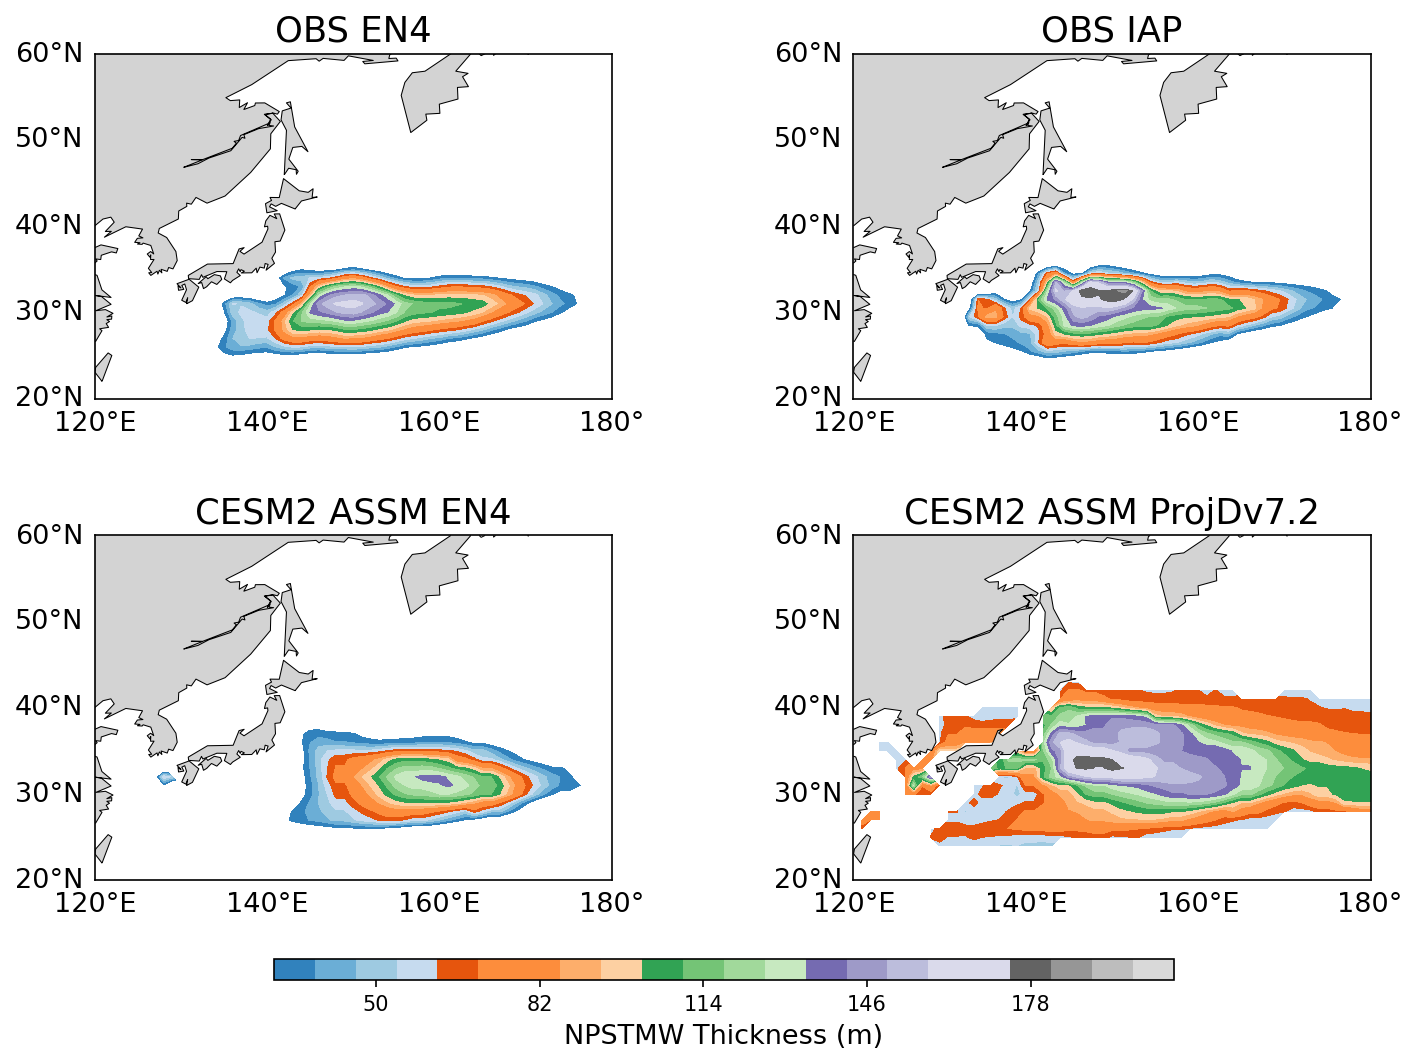

In [100]:
fig = plt.figure(figsize=(10,7))
gs  = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1,1,0.01], width_ratios=[1,1])

####################################################################################################################################################################################
domain = [20, 60, 10, 120, 180, 20]; cmap = plt.cm.tab20c; levs = np.arange(50,210.1,8)

ax = plt.subplot(gs[0,0]); ax.set_title('OBS EN4', fontsize=17)
data1 = OBS_EN4_STMWT.mean(dim='time'); data1 = data1.where(data1 != 0, np.nan)
cf1, lon1, lat1 = contour_map(data1, levs, domain, cmap, 'neither', f_size=13, xset=1.3, yset=1.3)

ax = plt.subplot(gs[0,1]); ax.set_title('OBS IAP', fontsize=17)
data1 = OBS_IAP_STMWT.mean(dim='time'); data1 = data1.where(data1 != 0, np.nan)
cf1, lon1, lat1 = contour_map(data1, levs, domain, cmap, 'neither', f_size=13, xset=1.3, yset=1.3)

ax = plt.subplot(gs[1,0]); ax.set_title('CESM2 ASSM EN4', fontsize=17)
data1 = ASM_EN4_STMWT_nan.mean(dim=['ens','time']); data1 = data1.where(data1 != 0, np.nan)
cf1, lon1, lat1 = contour_map(data1, levs, domain, cmap, 'neither', f_size=13, xset=1.3, yset=1.3)

ax = plt.subplot(gs[1,1]); ax.set_title('CESM2 ASSM ProjDv7.2', fontsize=17)
data1 = ASM_PD7_STMWT.mean(dim=['ens','time']); data1 = data1.where(data1 != 0, np.nan)
cf1, lon1, lat1 = contour_map(data1, levs, domain, cmap, 'neither', f_size=13, xset=1.3, yset=1.3)

cax = plt.axes([0.21,0.06,0.6,0.02]) # (left, bottom, width, height)
cb1 = plt.colorbar(cf1, cax=cax, orientation='horizontal', ticks=np.arange(50,210.1,32))
cb1.ax.tick_params(labelsize=10)
cb1.ax.set_xlabel('NPSTMW Thickness (m)', fontsize=13)

plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

In [5]:
data1 = OBS_EN4_STMWT.mean(dim='time'); data1 = data1.where(data1 != 0, np.nan)
OBS_EN4_STMWT_ZM = data1.sel(lon=slice(140,175)).mean(dim='lon')
data1 = OBS_IAP_STMWT.mean(dim='time'); data1 = data1.where(data1 != 0, np.nan)
OBS_IAP_STMWT_ZM = data1.sel(lon=slice(140,175)).mean(dim='lon')
data1 = ASM_EN4_STMWT.mean(dim='time'); data1 = data1.where(data1 != 0, np.nan)
ASM_EN4_STMWT_ZM = data1.sel(lon=slice(140,175)).mean(dim='lon')
data1 = ASM_PD7_STMWT.mean(dim='time'); data1 = data1.where(data1 != 0, np.nan)
ASM_PD7_STMWT_ZM = data1.sel(lon=slice(140,175)).mean(dim='lon')

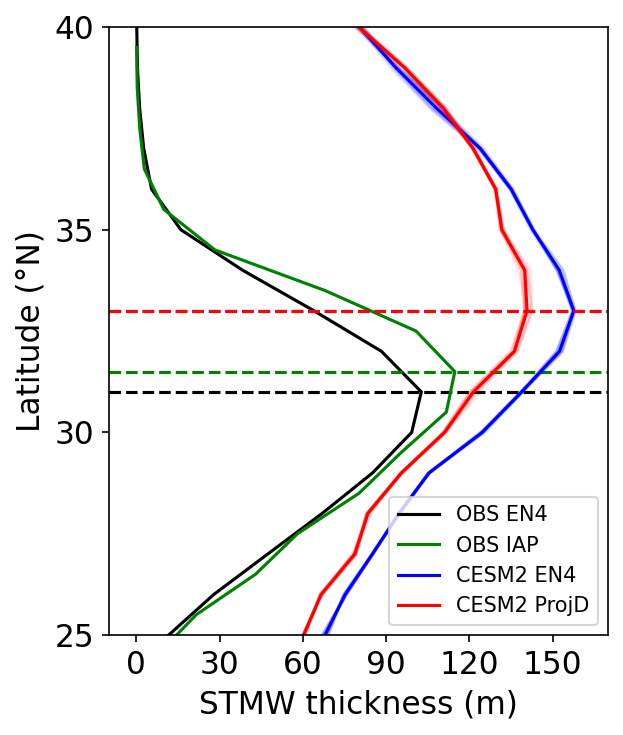

In [6]:
fig = plt.figure(figsize=(8,5))
gs  = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[1], width_ratios=[1,1])

####################################################################################################################################################################################
ax = plt.subplot(gs[0,0])#; ax.set_title('OBS EN4', fontsize=17)
data = OBS_EN4_STMWT_ZM; axis = data.lat[data.argmax()]
ax.plot(data, data.lat, c='k', label='OBS EN4'); ax.axhline(y=axis, c='k', linestyle='--')
data = OBS_IAP_STMWT_ZM; axis = data.lat[data.argmax()]
ax.plot(data, data.lat, c='g', label='OBS IAP'); ax.axhline(y=axis, c='g', linestyle='--')
data = ASM_EN4_STMWT_ZM; data_enm = ASM_EN4_STMWT_ZM.mean(axis=0); axis = data_enm.lat[data_enm.argmax().values]
ax.plot(data.transpose(),  data.lat, c='b', alpha=0.1); ax.plot(data_enm,      data_enm.lat, c='b', label='CESM2 EN4'); ax.axhline(y=axis, c='b', linestyle='--')
data = ASM_PD7_STMWT_ZM; data_enm = ASM_PD7_STMWT_ZM.mean(axis=0); axis = data_enm.lat[data_enm.argmax().values]
ax.plot(data.transpose(),  data.lat, c='r', alpha=0.1); ax.plot(data_enm,      data_enm.lat, c='r', label='CESM2 ProjD'); ax.axhline(y=axis, c='r', linestyle='--')

ax.set(xlim=(-10,170), xticks=np.arange(0,150.1,30), xlabel='STMW thickness (m)',
       ylim=(25,40),   yticks=np.arange(25,40.1,5),  ylabel='Latitude (°N)')
ax.legend(loc='lower right')

plt.tight_layout(w_pad=3)
plt.show()

In [7]:
clim_OBS_EN4_STMWV, anom_OBS_EN4_STMWV = calc_anomaly(OBS_EN4_STMWV)
clim_OBS_IAP_STMWV, anom_OBS_IAP_STMWV = calc_anomaly(OBS_IAP_STMWV)
clim_ASM_EN4_STMWV, anom_ASM_EN4_STMWV = calc_anomaly(ASM_EN4_STMWV)
clim_ASM_PD7_STMWV, anom_ASM_PD7_STMWV = calc_anomaly(ASM_PD7_STMWV)

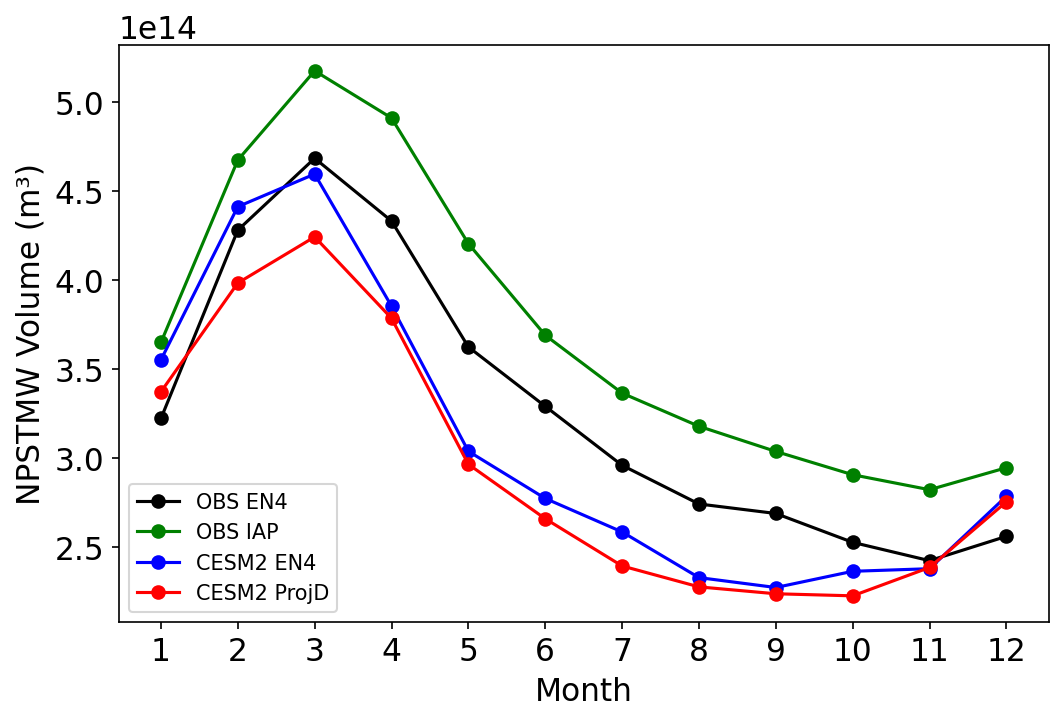

In [8]:
fig = plt.figure(figsize=(8,5))
gs  = gridspec.GridSpec(nrows=1, ncols=1, height_ratios=[1], width_ratios=[1])

month = np.arange(1,12.1,1)
####################################################################################################################################################################################
ax = plt.subplot(gs[0,0])#; ax.set_title('OBS EN4', fontsize=17)

ax.plot(month, clim_OBS_EN4_STMWV, '-ko', label='OBS EN4')
ax.plot(month, clim_OBS_IAP_STMWV, '-go', label='OBS IAP')
ax.plot(month, clim_ASM_EN4_STMWV.mean(axis=0), '-bo', label='CESM2 EN4')
ax.plot(month, clim_ASM_PD7_STMWV.mean(axis=0), '-ro', label='CESM2 ProjD')

ax.set(xticks=np.arange(1,12.1,1), xlabel='Month', ylabel='NPSTMW Volume (m³)')
ax.legend(loc='lower left', fontsize=10)

plt.show()

In [11]:
OBS_EN4_TZM_KOE   = OBS_EN4_TEMP.sel(lat=slice(20,50),lon=slice(150,151)).mean(dim=['time','lon'])
OBS_EN4_TGRAD_KOE = OBS_EN4_TZM_KOE.differentiate(coord='depth')*-10.

OBS_IAP_TZM_KOE   = OBS_IAP_TEMP.sel(lat=slice(20,50),lon=slice(150,151)).mean(dim=['time','lon'])
OBS_IAP_TGRAD_KOE = OBS_IAP_TZM_KOE.differentiate(coord='depth')*-10.

ASM_EN4_E01_TZM_KOE   = ASM_EN4_E01_TEMP.sel(lat=slice(20,50),lon=slice(150,151)).mean(dim=['time','lon'])
ASM_EN4_E01_TGRAD_KOE = ASM_EN4_E01_TZM_KOE.differentiate(coord='depth')*-10.

ASM_PJ7_E01_TZM_KOE   = ASM_PJ7_E01_TEMP.sel(lat=slice(20,50),lon=slice(150,151)).mean(dim=['time','lon'])
ASM_PJ7_E01_TGRAD_KOE = ASM_PJ7_E01_TZM_KOE.differentiate(coord='depth')*-10.

In [12]:
def contour_zm(data1, data2):
    cf1 = ax.contourf(data1.lat, data1.depth, data1, levels=lev1, cmap=plt.cm.RdBu_r, extend='both')
    ax.contour(data1.lat, data1.depth, data1, levels=[0.15], colors='w')
    ax.contour(data2.lat, data2.depth, data2, levels=lev2, colors='k', linewidths=0.5, linestyles='dashed')
    cs = ax.contour(data2.lat, data2.depth, data2, levels=[16,20], colors='k'); ax.clabel(cs, inline=True, colors='k', fontsize=8)
    ax.set_xlim([20,50]); ax.set_xticks(np.arange(20,50.1,5)); ax.set_xlabel('Latitude (°N)')
    ax.set_ylim([0,600]); ax.invert_yaxis(); ax.set_ylabel('Depth (m)')

    return cf1

/glade/derecho/scratch/sysong/tmp/ipykernel_123032/329759039.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=3, h_pad=3)


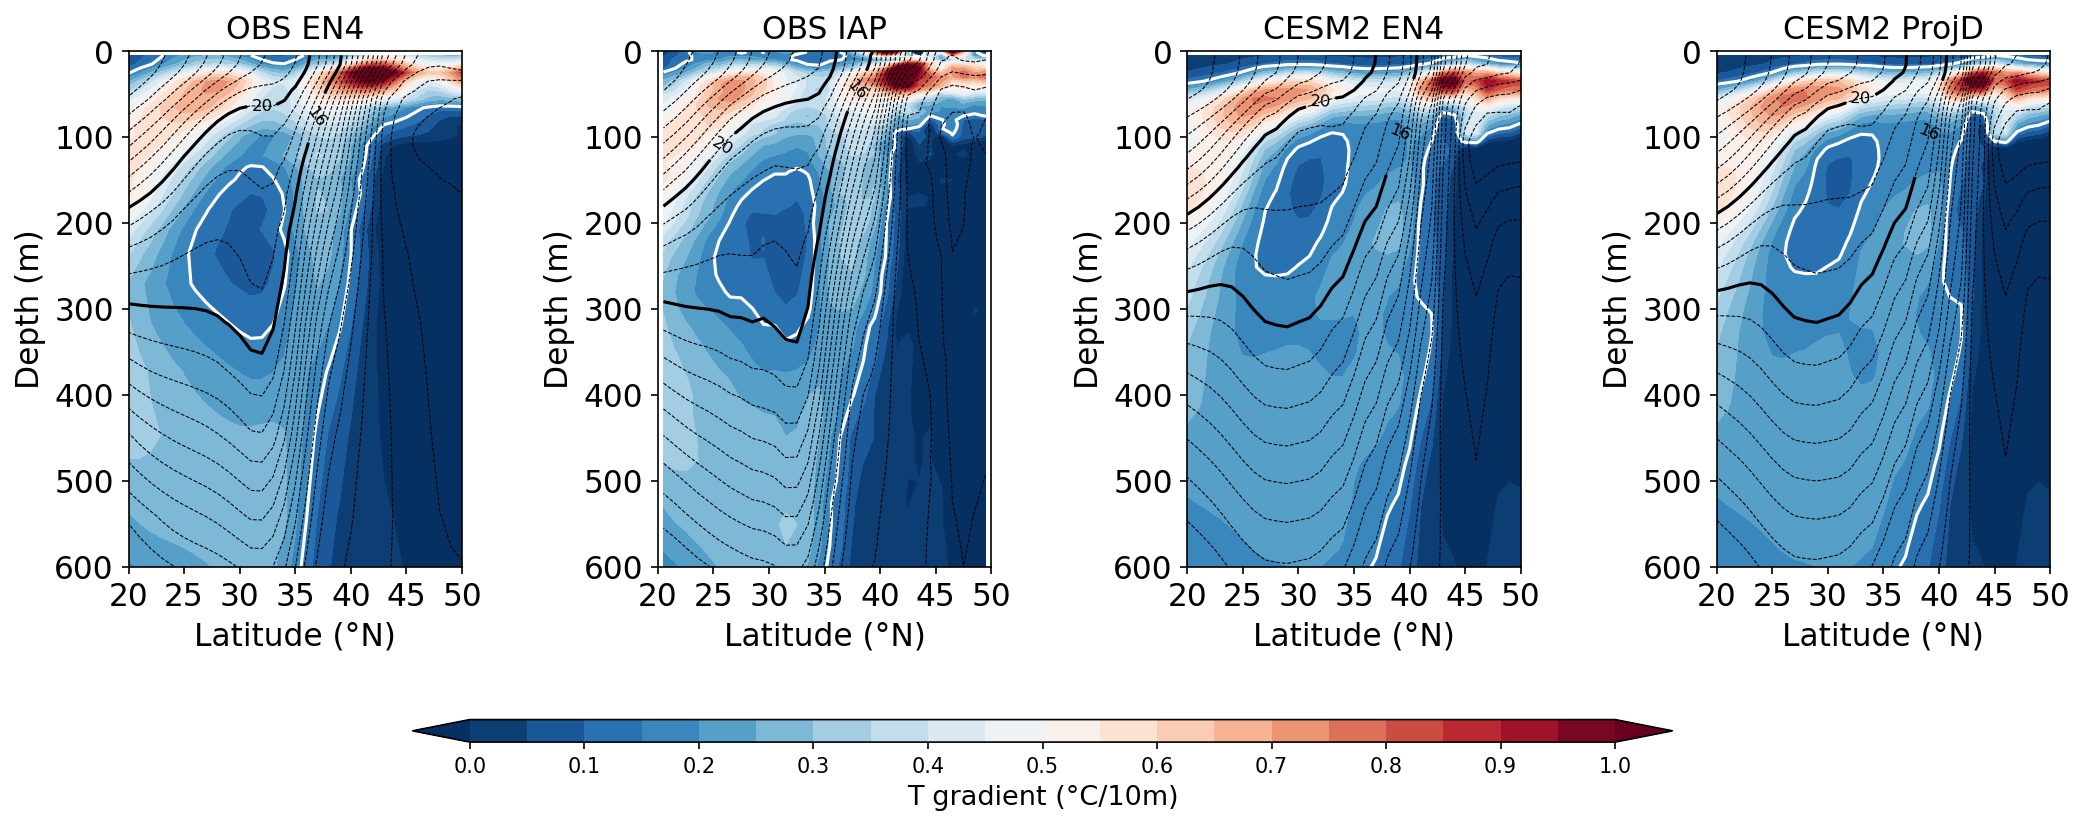

In [13]:
fig = plt.figure(figsize=(14,5))
gs  = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1,0.01], width_ratios=[1,1,1,1])

lev1 = np.arange(0,1.01,0.05); lev2 = np.arange(0,30.1,1)
####################################################################################################################################################################################
ax = plt.subplot(gs[0,0]); ax.set_title('OBS EN4', loc='center', fontsize=15)
cf1 = contour_zm(OBS_EN4_TGRAD_KOE, OBS_EN4_TZM_KOE)
ax = plt.subplot(gs[0,1]); ax.set_title('OBS IAP', loc='center', fontsize=15)
cf1 = contour_zm(OBS_IAP_TGRAD_KOE, OBS_IAP_TZM_KOE)
ax = plt.subplot(gs[0,2]); ax.set_title('CESM2 EN4', loc='center', fontsize=15)
cf1 = contour_zm(ASM_EN4_E01_TGRAD_KOE, ASM_EN4_E01_TZM_KOE)
ax = plt.subplot(gs[0,3]); ax.set_title('CESM2 ProjD', loc='center', fontsize=15)
cf1 = contour_zm(ASM_PJ7_E01_TGRAD_KOE, ASM_PJ7_E01_TZM_KOE)

cax = plt.axes([0.2,0.0,0.6,0.03]) # (left, bottom, width, height)
cb1 = plt.colorbar(cf1, cax=cax, orientation='horizontal', ticks=np.arange(0,1.01,0.1))
cb1.ax.tick_params(labelsize=10)
cb1.ax.set_xlabel('T gradient (°C/10m)', fontsize=13)

plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

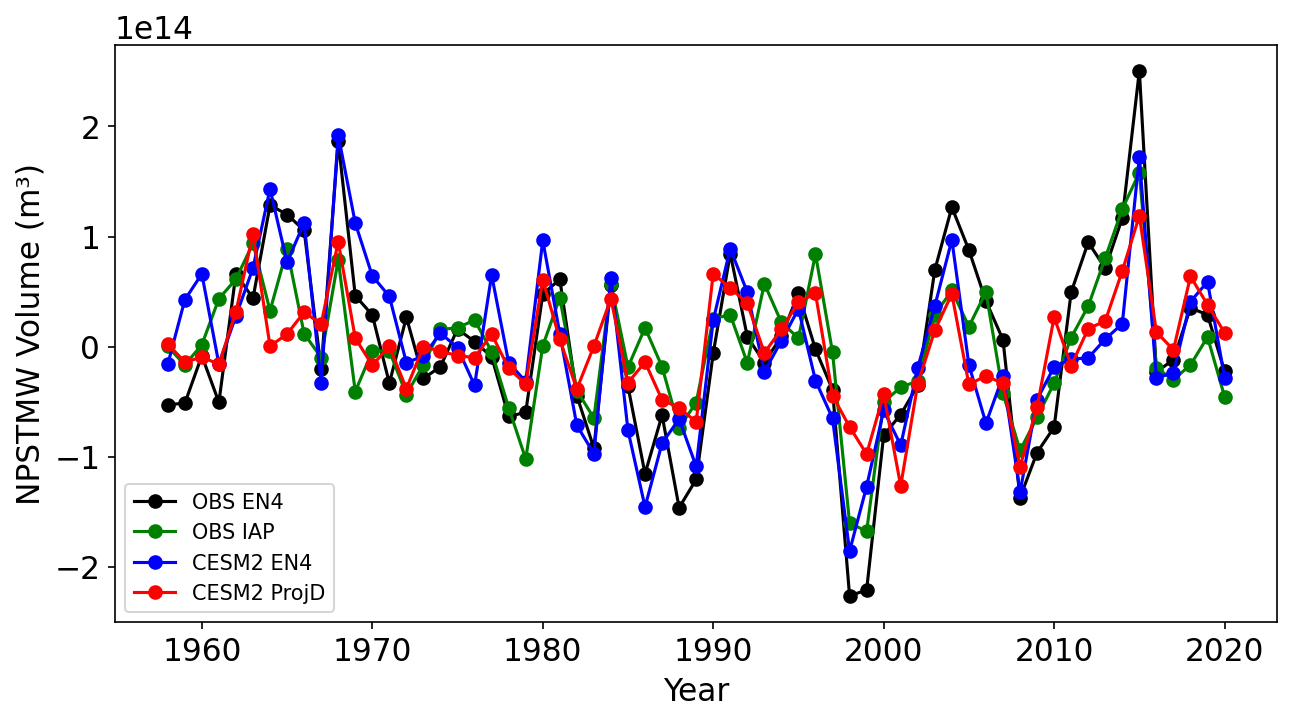

In [14]:
fig = plt.figure(figsize=(10,5))
gs  = gridspec.GridSpec(nrows=1, ncols=1, height_ratios=[1], width_ratios=[1])

year = np.arange(1958,2020.1,1)
####################################################################################################################################################################################
ax = plt.subplot(gs[0,0])#; ax.set_title('OBS EN4', fontsize=17)

ax.plot(year, season(anom_OBS_EN4_STMWV, [2,3,4]), '-ko', label='OBS EN4')
ax.plot(year, season(anom_OBS_IAP_STMWV, [2,3,4]), '-go', label='OBS IAP')
ax.plot(year, season(anom_ASM_EN4_STMWV.mean(axis=0), [2,3,4]), '-bo', label='CESM2 EN4')
ax.plot(year, season(anom_ASM_PD7_STMWV.mean(axis=0), [2,3,4]), '-ro', label='CESM2 ProjD')

ax.set(xticks=np.arange(1960,2020.1,10), xlabel='Year', ylabel='NPSTMW Volume (m³)')
ax.legend(loc='lower left', fontsize=10)

plt.show()

In [54]:
OBS_EN4_STMW = OBS_EN4['NPSTMW_volume'].sel(time=slice(fyear,eyear)).sum(dim=['depth'])
OBS_IAP_STMW = OBS_IAP['NPSTMW_volume'].sel(time=slice(fyear,eyear)).sum(dim=['depth'])
ASM_EN4_STMW = ASM_EN4['NPSTMW_volume'].sel(time=slice(fyear,eyear)).sum(dim=['depth'])
ASM_PD7_STMW = ASM_PD7['NPSTMW_volume'].sel(time=slice(fyear,eyear)).sum(dim=['depth'])

In [58]:
#OBS_EN4_STMWT_nan = OBS_EN4_STMW.where(OBS_EN4_STMW != 0, np.nan)
#clim_OBS_EN4_STMWT, anom_OBS_EN4_STMWT = calc_anomaly(OBS_EN4_STMWT_nan)
clim_OBS_EN4_STMWT, anom_OBS_EN4_STMWT = calc_anomaly(OBS_EN4_STMWT)
anom_OBS_EN4_STMWT_137E = anom_OBS_EN4_STMWT.sel(lon=slice(137,137), lat=slice(10,35)).squeeze()
anom_OBS_EN4_STMWT_145E = anom_OBS_EN4_STMWT.sel(lon=slice(145,145), lat=slice(10,40)).squeeze()
anom_OBS_EN4_STMWT_150E = anom_OBS_EN4_STMWT.sel(lon=slice(150,150), lat=slice(10,40)).squeeze()

#ASM_EN4_STMWT_nan = ASM_EN4_STMW.fillna(0)
#clim_ASM_EN4_STMWT, anom_ASM_EN4_STMWT = calc_anomaly(ASM_EN4_STMWT_nan[0])
clim_ASM_EN4_STMWT, anom_ASM_EN4_STMWT = calc_anomaly(ASM_EN4_STMWT[0].fillna(0))
anom_ASM_EN4_STMWT_137E = anom_ASM_EN4_STMWT.sel(lon=slice(137,137), lat=slice(10,40)).squeeze()
anom_ASM_EN4_STMWT_145E = anom_ASM_EN4_STMWT.sel(lon=slice(145,145), lat=slice(10,40)).squeeze()
anom_ASM_EN4_STMWT_150E = anom_ASM_EN4_STMWT.sel(lon=slice(150,150), lat=slice(10,40)).squeeze()

In [73]:
clim_ASM_EN4_E01_DIC_STMWW, anom_ASM_EN4_E01_DIC_STMWW = calc_anomaly(ASM_EN4_E01_DIC_STMWW)
anom_ASM_EN4_E01_DIC_STMWW_137E = anom_ASM_EN4_E01_DIC_STMWW.sel(lon=slice(137,137), lat=slice(10,40)).squeeze()
anom_ASM_EN4_E01_DIC_STMWW_145E = anom_ASM_EN4_E01_DIC_STMWW.sel(lon=slice(145,145), lat=slice(10,40)).squeeze()
anom_ASM_EN4_E01_DIC_STMWW_150E = anom_ASM_EN4_E01_DIC_STMWW.sel(lon=slice(150,150), lat=slice(10,40)).squeeze()

clim_ASM_EN4_E01_DIC_ALT_CO2_STMWW, anom_ASM_EN4_E01_DIC_ALT_CO2_STMWW = calc_anomaly(ASM_EN4_E01_DIC_ALT_CO2_STMWW)
anom_ASM_EN4_E01_DIC_ALT_CO2_STMWW_137E = anom_ASM_EN4_E01_DIC_ALT_CO2_STMWW.sel(lon=slice(137,137), lat=slice(10,40)).squeeze()
anom_ASM_EN4_E01_DIC_ALT_CO2_STMWW_145E = anom_ASM_EN4_E01_DIC_ALT_CO2_STMWW.sel(lon=slice(145,145), lat=slice(10,40)).squeeze()
anom_ASM_EN4_E01_DIC_ALT_CO2_STMWW_150E = anom_ASM_EN4_E01_DIC_ALT_CO2_STMWW.sel(lon=slice(150,150), lat=slice(10,40)).squeeze()

clim_ASM_EN4_E01_ADIC_STMWW, anom_ASM_EN4_E01_ADIC_STMWW = calc_anomaly(ASM_EN4_E01_ADIC_STMWW)
anom_ASM_EN4_E01_ADIC_STMWW_137E = anom_ASM_EN4_E01_ADIC_STMWW.sel(lon=slice(137,137), lat=slice(10,40)).squeeze()
anom_ASM_EN4_E01_ADIC_STMWW_145E = anom_ASM_EN4_E01_ADIC_STMWW.sel(lon=slice(145,145), lat=slice(10,40)).squeeze()
anom_ASM_EN4_E01_ADIC_STMWW_150E = anom_ASM_EN4_E01_ADIC_STMWW.sel(lon=slice(150,150), lat=slice(10,40)).squeeze()

/glade/derecho/scratch/sysong/tmp/ipykernel_159894/1738998169.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=3)


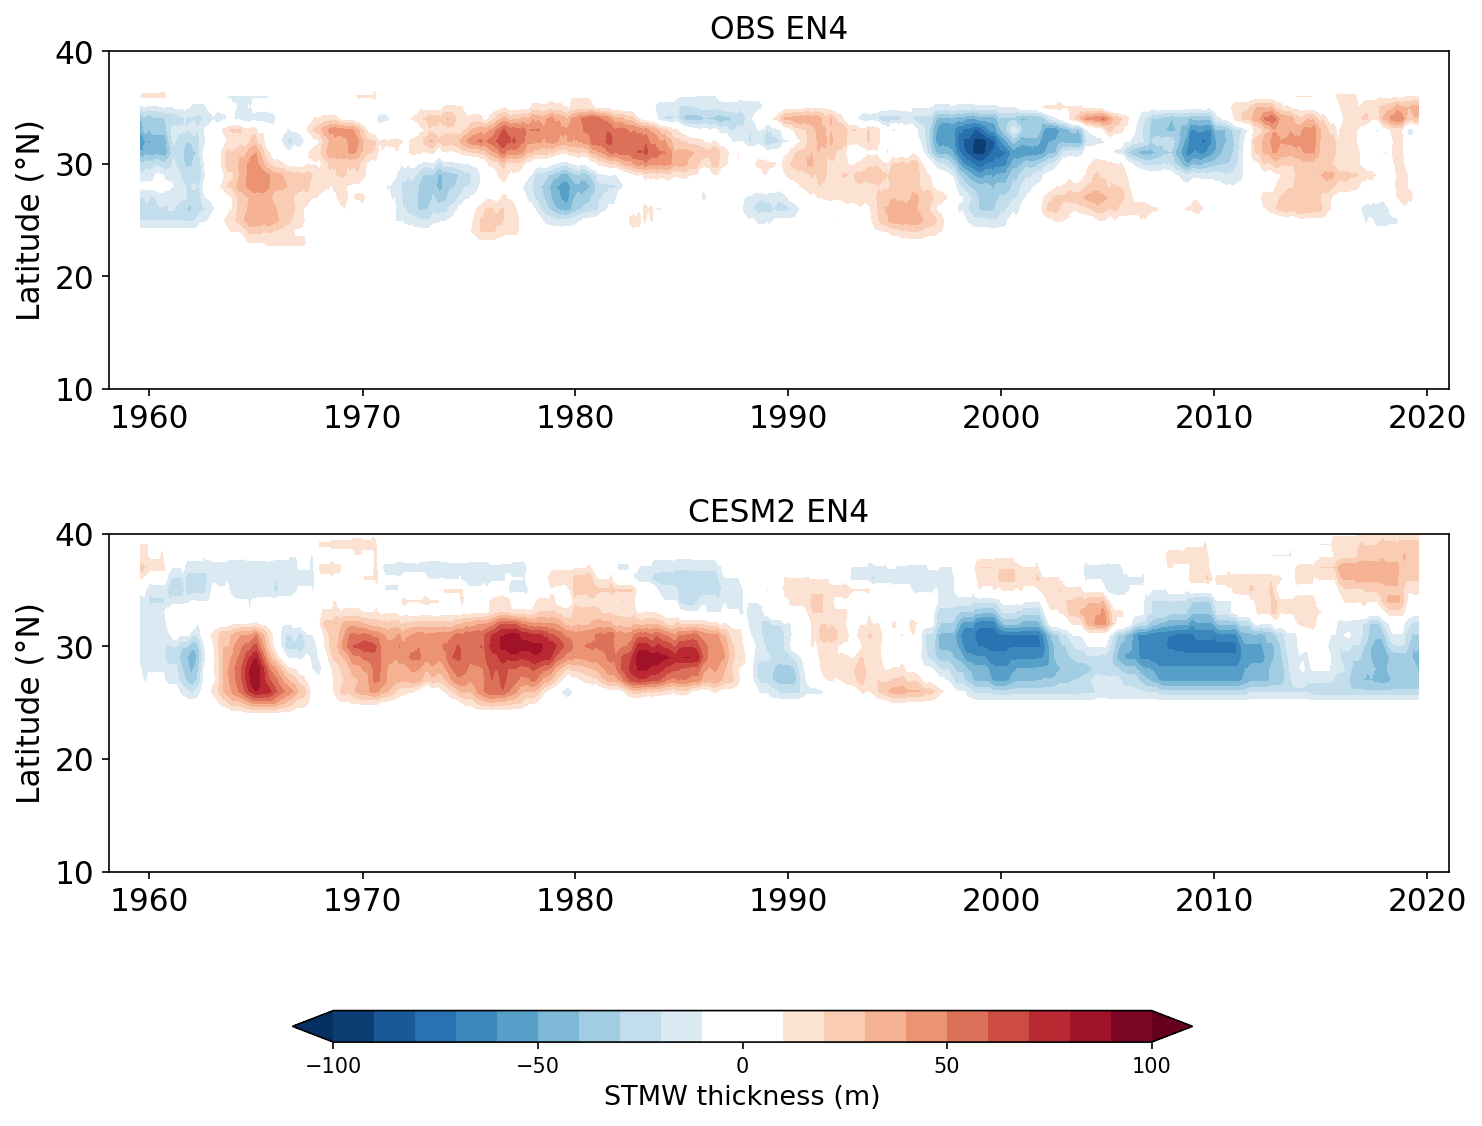

In [56]:
fig = plt.figure(figsize=(10,7))
gs  = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[1,1,0.01], width_ratios=[1])

lev = np.arange(-100,100.1,10)
####################################################################################################################################################################################
ax = plt.subplot(gs[0,0]); ax.set_title('OBS EN4', loc='center', fontsize=15)
data = anom_OBS_EN4_STMWT_150E; data_3yr = data.rolling(time=36, center=True).mean()
ax.contourf(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap_RdBu_r, levels=lev, extend='both')
ax.set_ylabel('Latitude (°N)')

ax = plt.subplot(gs[1,0]); ax.set_title('CESM2 EN4', loc='center', fontsize=15)
data = anom_ASM_EN4_STMWT_150E; data_3yr = data.rolling(time=36, center=True).mean()
cf = ax.contourf(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap_RdBu_r, levels=lev, extend='both')
ax.set_ylabel('Latitude (°N)')

cax = plt.axes([0.2,0.0,0.6,0.03]) # (left, bottom, width, height)
cb1 = plt.colorbar(cf, cax=cax, orientation='horizontal', ticks=lev[::5])
cb1.ax.tick_params(labelsize=10)
cb1.ax.set_xlabel('STMW thickness (m)', fontsize=13)

plt.tight_layout(h_pad=3)
plt.show()

/glade/derecho/scratch/sysong/tmp/ipykernel_159894/2949310257.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


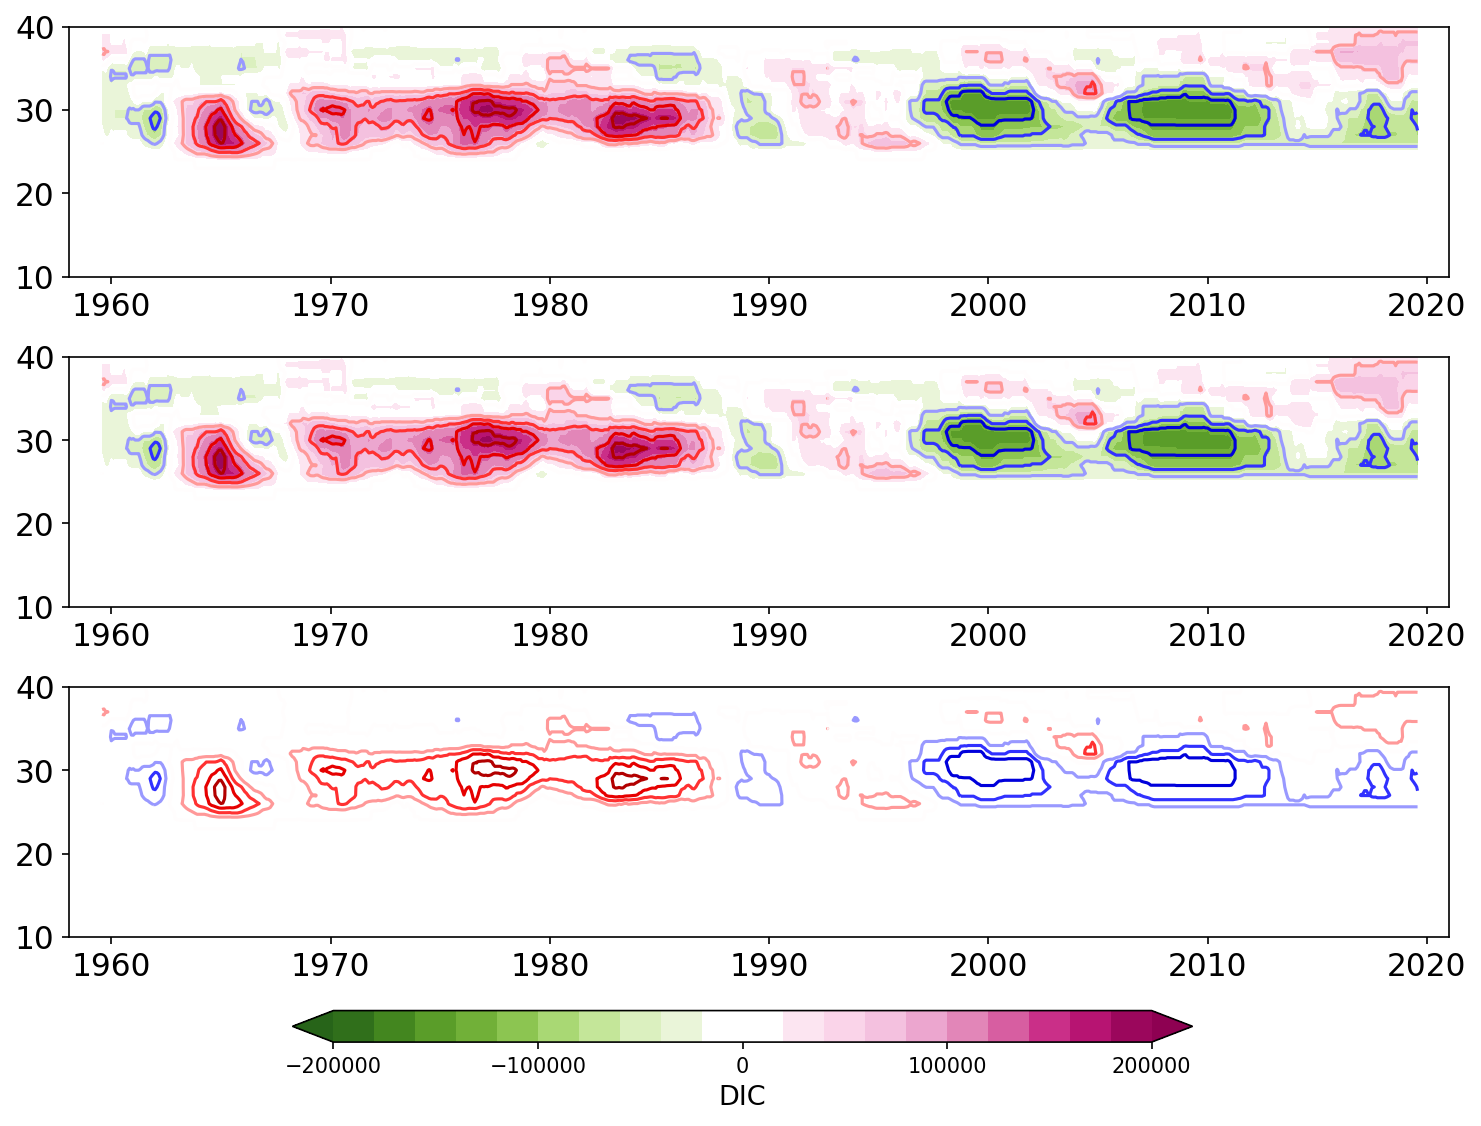

In [95]:
fig = plt.figure(figsize=(10,7))
gs  = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[1,1,1,0.01], width_ratios=[1])

lev = np.arange(-200,200.1,20)*1e3; cmap=cmap_PiYG_r; lev2 = np.arange(-100,100.1,20); cmap2=plt.cm.seismic
####################################################################################################################################################################################
ax = plt.subplot(gs[0,0]); #ax.set_title('Total DIC', loc='center', fontsize=15)
data = anom_ASM_EN4_E01_DIC_STMWW_150E; data_3yr = data.rolling(time=36, center=True).mean()
cf = ax.contourf(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap, levels=lev, extend='both')
data = anom_ASM_EN4_STMWT_150E; data_3yr = data.rolling(time=36, center=True).mean()
ax.contour(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap2, levels=lev2)

ax = plt.subplot(gs[1,0]); #ax.set_title('Total DIC', loc='center', fontsize=15)
data = anom_ASM_EN4_E01_DIC_ALT_CO2_STMWW_150E; data_3yr = data.rolling(time=36, center=True).mean()
cf = ax.contourf(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap, levels=lev, extend='both')
data = anom_ASM_EN4_STMWT_150E; data_3yr = data.rolling(time=36, center=True).mean()
ax.contour(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap2, levels=lev2)

ax = plt.subplot(gs[2,0]); #ax.set_title('Total DIC', loc='center', fontsize=15)
data = anom_ASM_EN4_E01_ADIC_STMWW_150E; data_3yr = data.rolling(time=36, center=True).mean()
cf = ax.contourf(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap, levels=lev, extend='both')
data = anom_ASM_EN4_STMWT_150E; data_3yr = data.rolling(time=36, center=True).mean()
ax.contour(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap2, levels=lev2)

cax = plt.axes([0.2,0.0,0.6,0.03]) # (left, bottom, width, height)
cb1 = plt.colorbar(cf, cax=cax, orientation='horizontal', ticks=lev[::5])
cb1.ax.tick_params(labelsize=10)
cb1.ax.set_xlabel('DIC', fontsize=13)

plt.tight_layout()
plt.show()

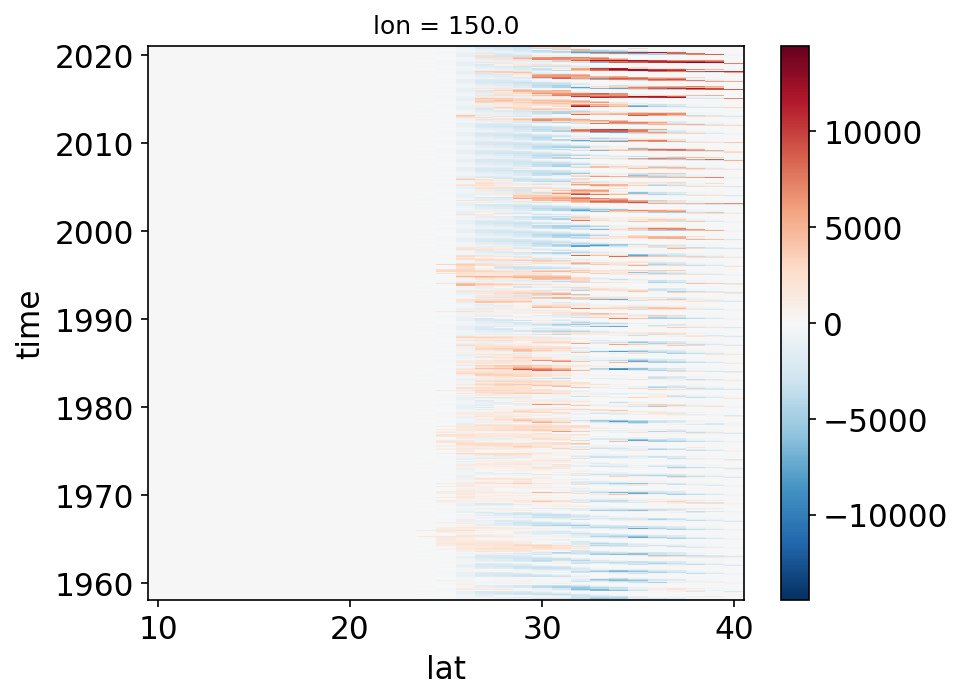

In [91]:
anom_ASM_EN4_E01_ADIC_STMWW_150E.plot()

In [191]:
clim_ASM_EN4_DIC, anom_ASM_EN4_DIC = calc_anomaly(ASM_EN4_E01_DIC_int.fillna(0))
anom_ASM_EN4_DIC_137E = anom_ASM_EN4_DIC.sel(lon=slice(137,137), lat=slice(10,40)).squeeze()
anom_ASM_EN4_DIC_145E = anom_ASM_EN4_DIC.sel(lon=slice(145,145), lat=slice(10,40)).squeeze()
anom_ASM_EN4_DIC_150E = anom_ASM_EN4_DIC.sel(lon=slice(150,150), lat=slice(10,40)).squeeze()

clim_ASM_EN4_DIC_ALT_CO2, anom_ASM_EN4_DIC_ALT_CO2 = calc_anomaly(ASM_EN4_E01_DIC_ALT_CO2_int.fillna(0))
anom_ASM_EN4_DIC_ALT_CO2_137E = anom_ASM_EN4_DIC_ALT_CO2.sel(lon=slice(137,137), lat=slice(10,40)).squeeze()
anom_ASM_EN4_DIC_ALT_CO2_145E = anom_ASM_EN4_DIC_ALT_CO2.sel(lon=slice(145,145), lat=slice(10,40)).squeeze()
anom_ASM_EN4_DIC_ALT_CO2_150E = anom_ASM_EN4_DIC_ALT_CO2.sel(lon=slice(150,150), lat=slice(10,40)).squeeze()

clim_ASM_EN4_ACO2, anom_ASM_EN4_ACO2 = calc_anomaly(ASM_EN4_E01_ACO2_int.fillna(0))
anom_ASM_EN4_ACO2_137E = anom_ASM_EN4_ACO2.sel(lon=slice(137,137), lat=slice(10,40)).squeeze()
anom_ASM_EN4_ACO2_145E = anom_ASM_EN4_ACO2.sel(lon=slice(145,145), lat=slice(10,40)).squeeze()
anom_ASM_EN4_ACO2_150E = anom_ASM_EN4_ACO2.sel(lon=slice(150,150), lat=slice(10,40)).squeeze()

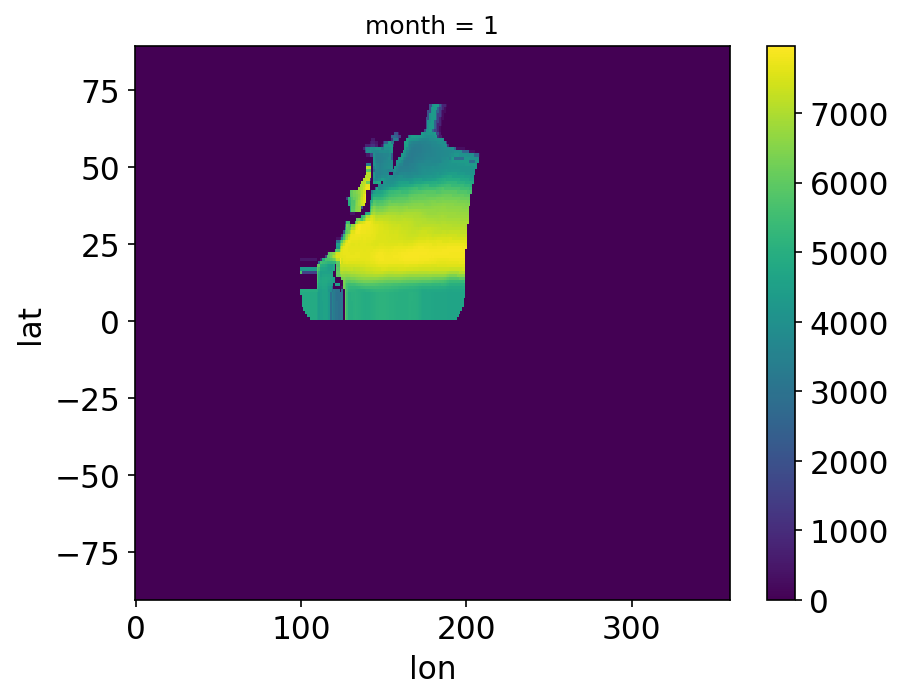

In [302]:
clim_ASM_EN4_ACO2[0].plot()

/glade/derecho/scratch/sysong/tmp/ipykernel_123032/2166740896.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=1)


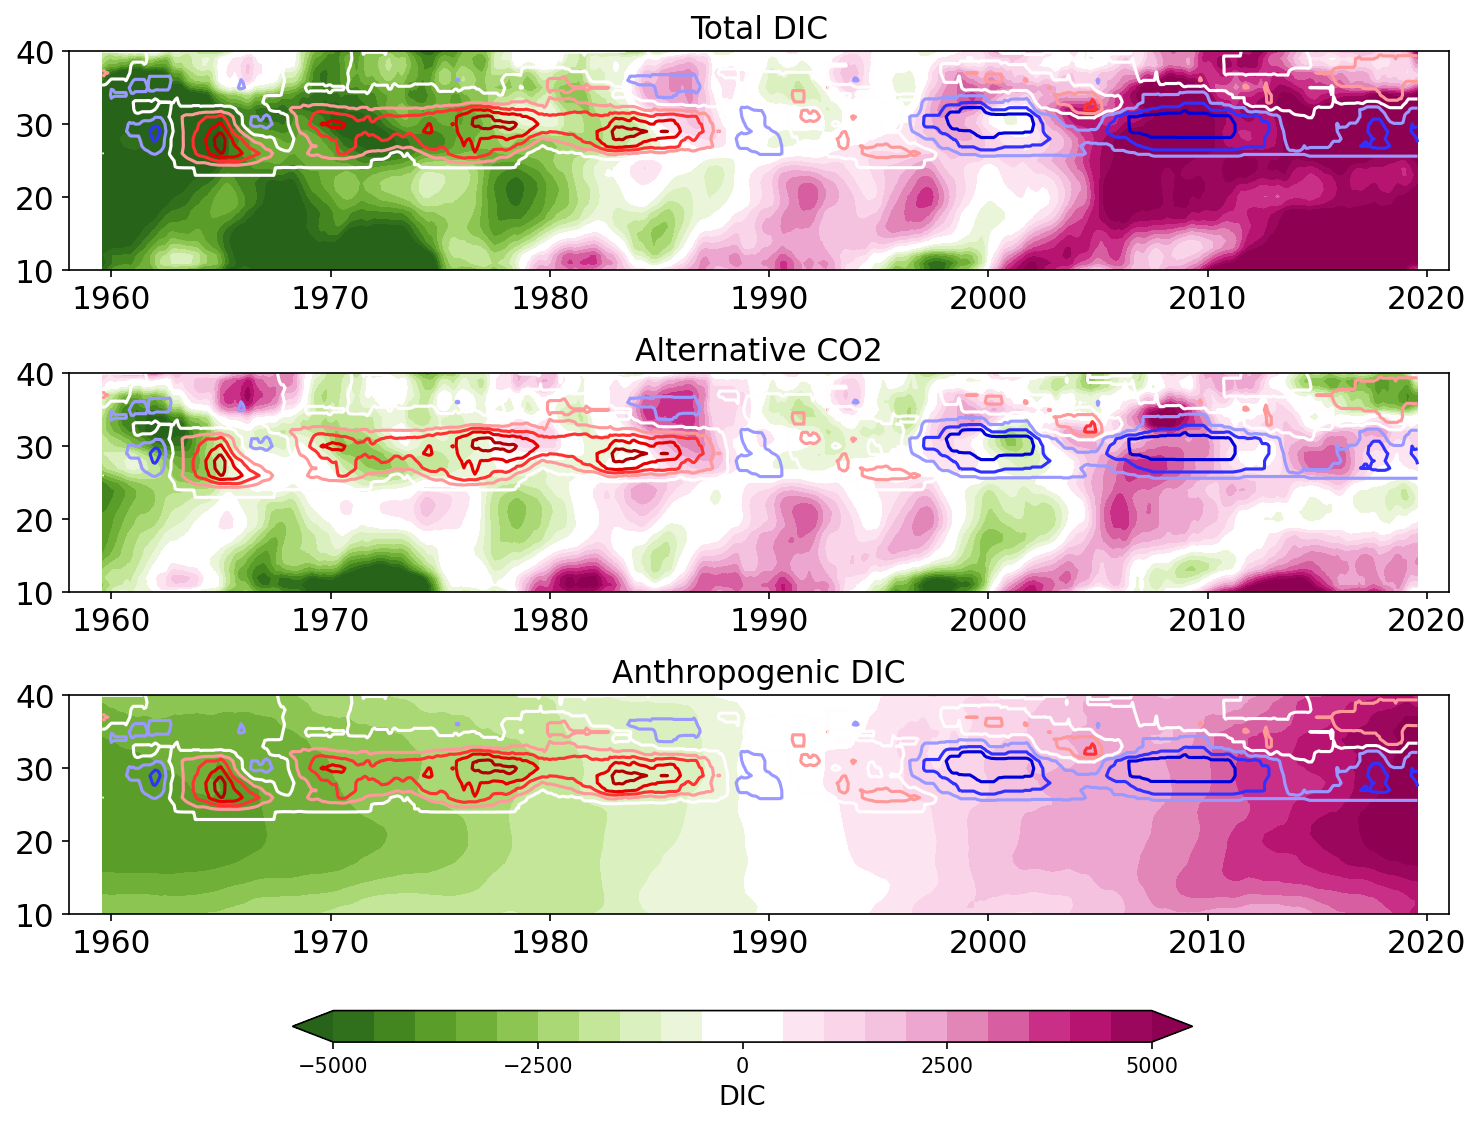

In [290]:
fig = plt.figure(figsize=(10,7))
gs  = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[1,1,1,0.01], width_ratios=[1])

lev = np.arange(-500,500.1,50)*1e1; cmap=cmap_PiYG_r; lev2 = np.arange(-100,100.1,20); cmap2=plt.cm.seismic
####################################################################################################################################################################################
ax = plt.subplot(gs[0,0]); ax.set_title('Total DIC', loc='center', fontsize=15)
data = anom_ASM_EN4_DIC_150E; data_3yr = data.rolling(time=36, center=True).mean()
ax.contourf(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap, levels=lev, extend='both')
data = anom_ASM_EN4_STMWT_150E; data_3yr = data.rolling(time=36, center=True).mean()
ax.contour(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap2, levels=lev2)

ax = plt.subplot(gs[1,0]); ax.set_title('Alternative CO2', loc='center', fontsize=15)
data = anom_ASM_EN4_DIC_ALT_CO2_150E; data_3yr = data.rolling(time=36, center=True).mean()
ax.contourf(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap, levels=lev, extend='both')
data = anom_ASM_EN4_STMWT_150E; data_3yr = data.rolling(time=36, center=True).mean()
ax.contour(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap2, levels=lev2)

ax = plt.subplot(gs[2,0]); ax.set_title('Anthropogenic DIC', loc='center', fontsize=15)
data = anom_ASM_EN4_ACO2_150E; data_3yr = data.rolling(time=36, center=True).mean()
cf = ax.contourf(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap, levels=lev, extend='both')
data = anom_ASM_EN4_STMWT_150E; data_3yr = data.rolling(time=36, center=True).mean()
ax.contour(data_3yr.time, data_3yr.lat, data_3yr.transpose(), cmap=cmap2, levels=lev2)

cax = plt.axes([0.2,0.0,0.6,0.03]) # (left, bottom, width, height)
cb1 = plt.colorbar(cf, cax=cax, orientation='horizontal', ticks=lev[::5])
cb1.ax.tick_params(labelsize=10)
cb1.ax.set_xlabel('DIC', fontsize=13)

plt.tight_layout(h_pad=1)
plt.show()

In [248]:
def contour_zm2(data1, data2, data3):
    cf1 = ax.contourf(data1.lat, data1.depth, data1, levels=lev1, cmap=plt.cm.viridis, extend='both')
    ax.contour(data3.lat, data3.depth, data3, levels=[0.15], colors='w', linewidths=1.5)
    ax.contour(data2.lat, data2.depth, data2, levels=lev2, colors='k', linewidths=0.5, linestyles='dashed')
    cs = ax.contour(data2.lat, data2.depth, data2, levels=[16,20], colors='k'); ax.clabel(cs, inline=True, colors='k', fontsize=8)
    ax.set_xlim([20,50]); ax.set_xticks(np.arange(20,50.1,5)); ax.set_xlabel('Latitude (°N)')
    ax.set_ylim([0,600]); ax.invert_yaxis(); ax.set_ylabel('Depth (m)')

    return cf1

In [296]:
clim_ASM_EN4_E01_DIC,  anom_ASM_EN4_E01_DIC  = calc_anomaly(ASM_EN4_E01_DIC.sel(time=slice('1998','2020'),lat=slice(20,50),lon=slice(150,151)).mean(dim=['lon']))
clim_ASM_EN4_E01_ACO2, anom_ASM_EN4_E01_ACO2 = calc_anomaly(ASM_EN4_E01_ACO2.sel(time=slice('1998','2020'),lat=slice(20,50),lon=slice(150,151)).mean(dim=['lon']))
clim_ASM_EN4_E01_DIC_ALT_CO2, anom_ASM_EN4_E01_DIC_ALT_CO2 = calc_anomaly(ASM_EN4_E01_DIC_ALT_CO2.sel(time=slice('1998','2020'),lat=slice(20,50),lon=slice(150,151)).mean(dim=['lon']))
clim_ASM_EN4_E01_DGRAD_ALT_CO2 = clim_ASM_EN4_E01_DIC_ALT_CO2.differentiate(coord='depth')

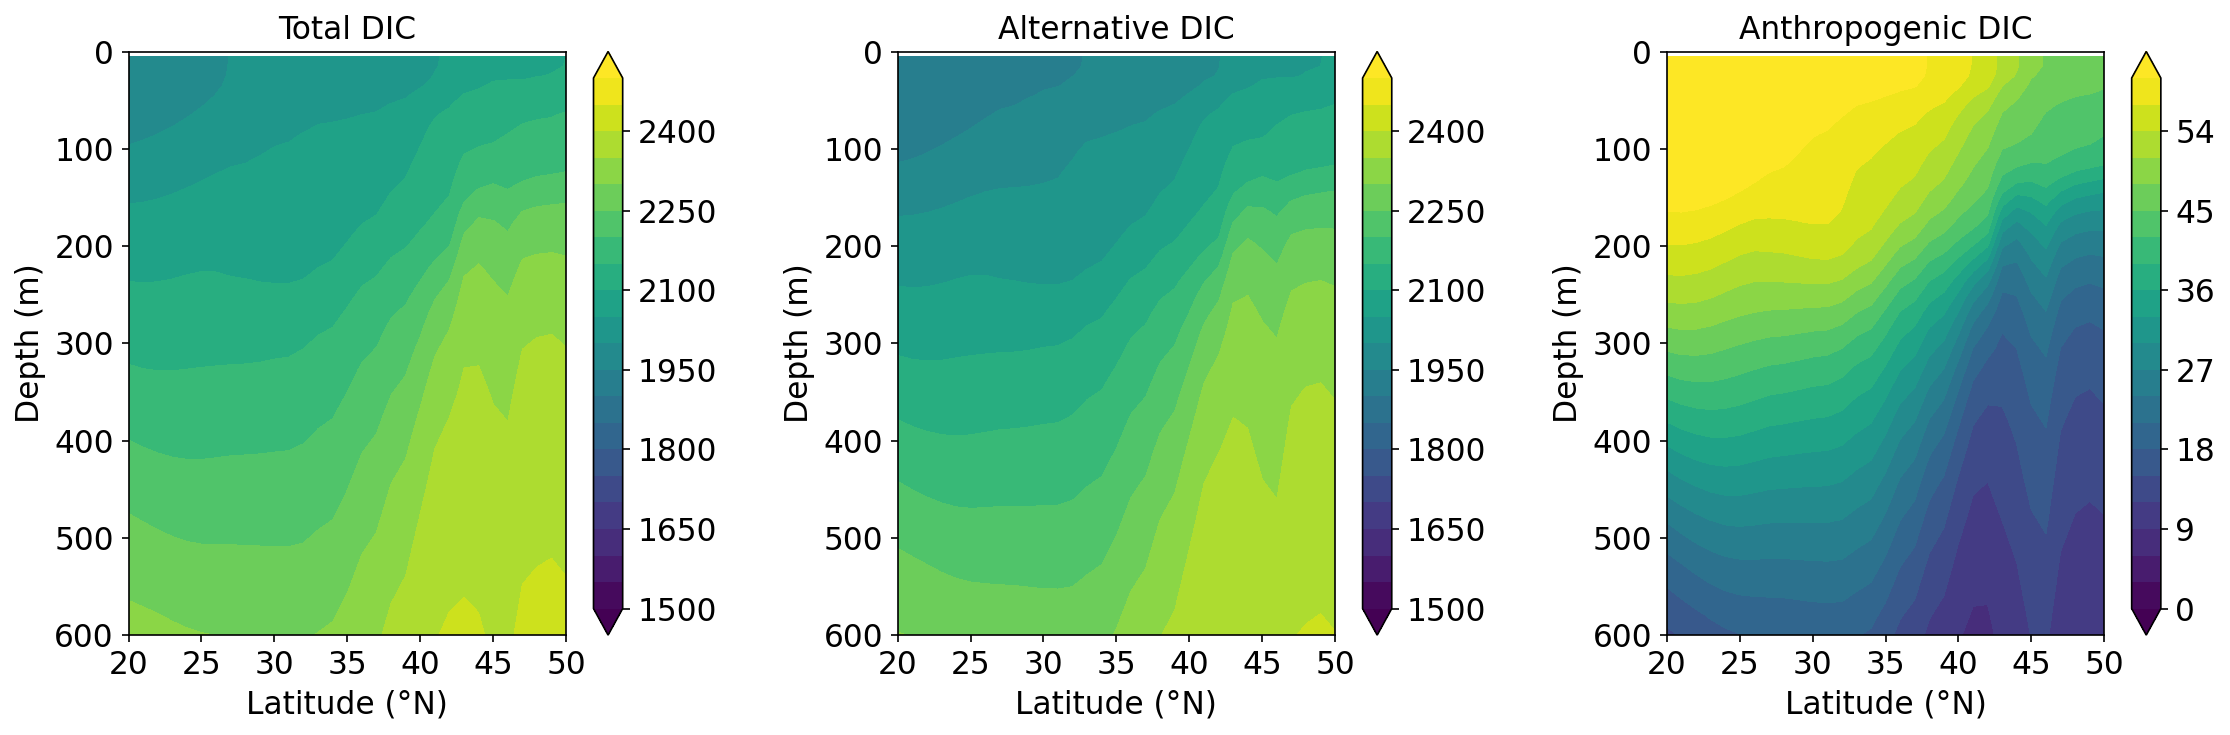

In [297]:
fig = plt.figure(figsize=(15,5))
gs  = gridspec.GridSpec(nrows=1, ncols=3, height_ratios=[1], width_ratios=[1,1,1])

lev1 = np.arange(1500,2500.1,50); lev2 = np.arange(0,60.1,3)

ax = plt.subplot(gs[0]); ax.set_title('Total DIC', loc='center', fontsize=15)
cf = ax.contourf(clim_ASM_EN4_E01_DIC.lat, clim_ASM_EN4_E01_DIC.depth, clim_ASM_EN4_E01_DIC.mean(axis=0), levels=lev1, cmap=plt.cm.viridis, extend='both')
plt.colorbar(cf, orientation='vertical')
ax.set_xlim([20,50]); ax.set_xticks(np.arange(20,50.1,5)); ax.set_xlabel('Latitude (°N)')
ax.set_ylim([0,600]); ax.invert_yaxis(); ax.set_ylabel('Depth (m)')

ax = plt.subplot(gs[1]); ax.set_title('Alternative DIC', loc='center', fontsize=15)
cf = ax.contourf(clim_ASM_EN4_E01_DIC.lat, clim_ASM_EN4_E01_DIC.depth, clim_ASM_EN4_E01_DIC_ALT_CO2.mean(axis=0), levels=lev1, cmap=plt.cm.viridis, extend='both')
plt.colorbar(cf, orientation='vertical')
ax.set_xlim([20,50]); ax.set_xticks(np.arange(20,50.1,5)); ax.set_xlabel('Latitude (°N)')
ax.set_ylim([0,600]); ax.invert_yaxis(); ax.set_ylabel('Depth (m)')

ax = plt.subplot(gs[2]); ax.set_title('Anthropogenic DIC', loc='center', fontsize=15)
cf = ax.contourf(clim_ASM_EN4_E01_DIC.lat, clim_ASM_EN4_E01_DIC.depth, clim_ASM_EN4_E01_ACO2.mean(axis=0), levels=lev2, cmap=plt.cm.viridis, extend='both')
plt.colorbar(cf, orientation='vertical')
ax.set_xlim([20,50]); ax.set_xticks(np.arange(20,50.1,5)); ax.set_xlabel('Latitude (°N)')
ax.set_ylim([0,600]); ax.invert_yaxis(); ax.set_ylabel('Depth (m)')

plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

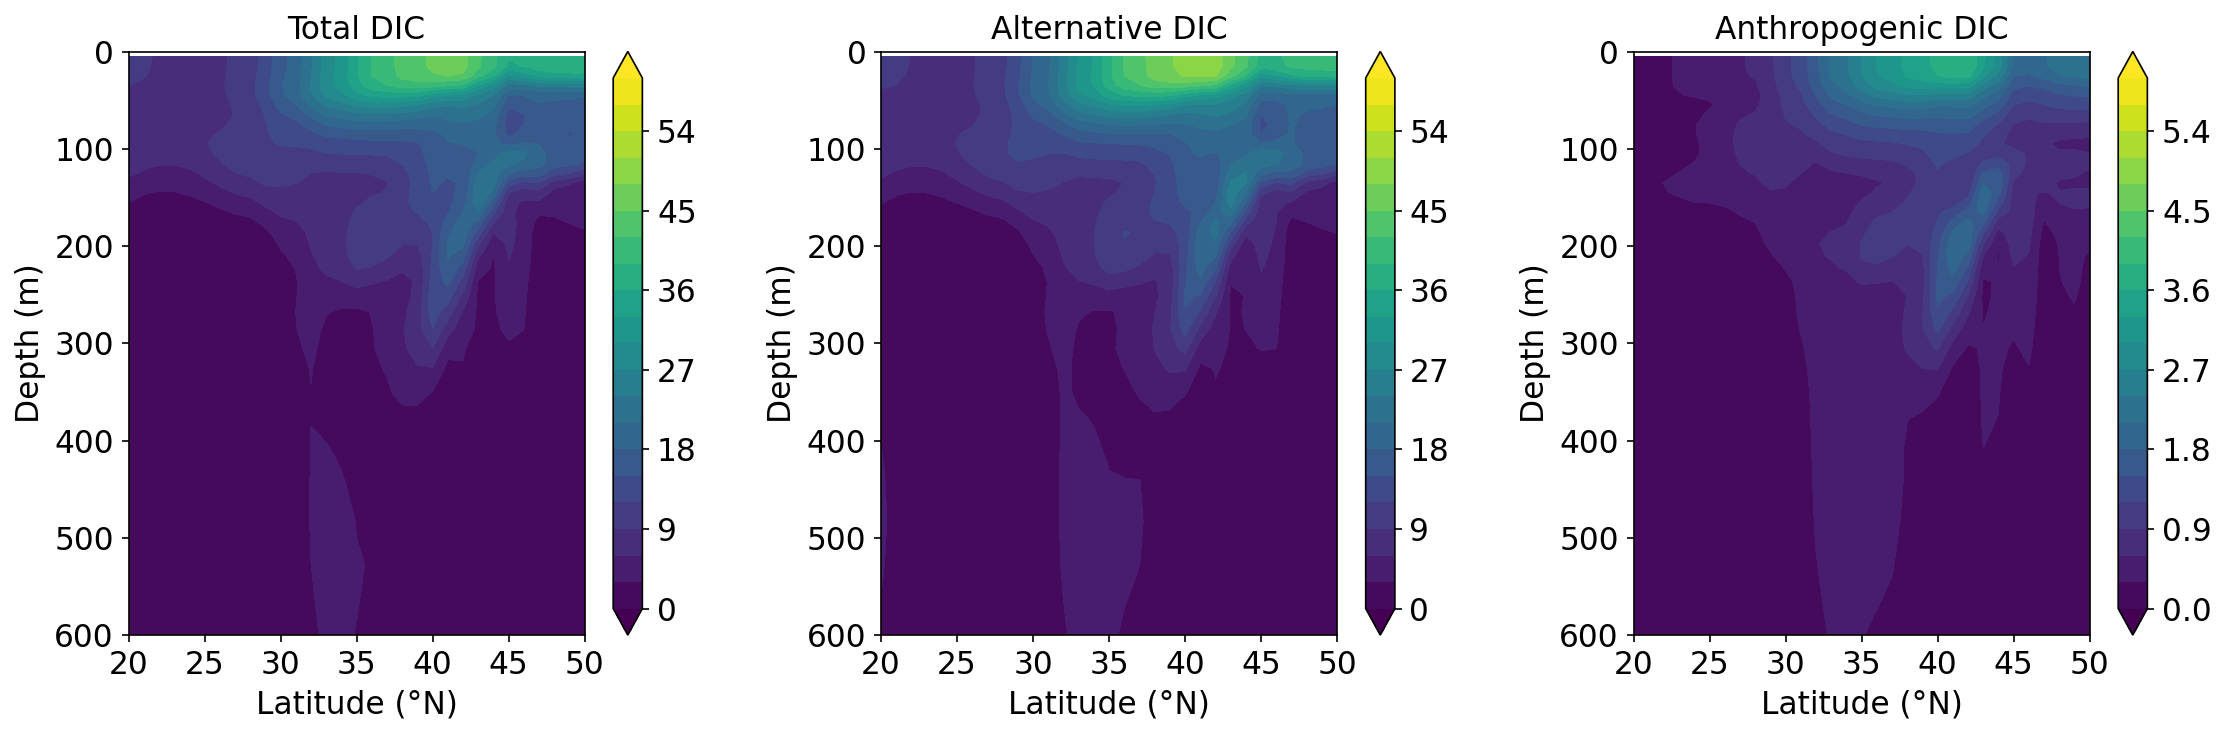

In [285]:
fig = plt.figure(figsize=(15,5))
gs  = gridspec.GridSpec(nrows=1, ncols=3, height_ratios=[1], width_ratios=[1,1,1])

lev1 = np.arange(0,60.1,3); lev2 = np.arange(0,6.1,0.3)

ax = plt.subplot(gs[0]); ax.set_title('Total DIC', loc='center', fontsize=15)
cf = ax.contourf(clim_ASM_EN4_E01_DIC.lat, clim_ASM_EN4_E01_DIC.depth, clim_ASM_EN4_E01_DIC.std(axis=0), levels=lev1, cmap=plt.cm.viridis, extend='both')
plt.colorbar(cf, orientation='vertical')
ax.set_xlim([20,50]); ax.set_xticks(np.arange(20,50.1,5)); ax.set_xlabel('Latitude (°N)')
ax.set_ylim([0,600]); ax.invert_yaxis(); ax.set_ylabel('Depth (m)')

ax = plt.subplot(gs[1]); ax.set_title('Alternative DIC', loc='center', fontsize=15)
cf = ax.contourf(clim_ASM_EN4_E01_DIC.lat, clim_ASM_EN4_E01_DIC.depth, clim_ASM_EN4_E01_DIC_ALT_CO2.std(axis=0), levels=lev1, cmap=plt.cm.viridis, extend='both')
plt.colorbar(cf, orientation='vertical')
ax.set_xlim([20,50]); ax.set_xticks(np.arange(20,50.1,5)); ax.set_xlabel('Latitude (°N)')
ax.set_ylim([0,600]); ax.invert_yaxis(); ax.set_ylabel('Depth (m)')

ax = plt.subplot(gs[2]); ax.set_title('Anthropogenic DIC', loc='center', fontsize=15)
cf = ax.contourf(clim_ASM_EN4_E01_DIC.lat, clim_ASM_EN4_E01_DIC.depth, clim_ASM_EN4_E01_ACO2.std(axis=0), levels=lev2, cmap=plt.cm.viridis, extend='both')
plt.colorbar(cf, orientation='vertical')
ax.set_xlim([20,50]); ax.set_xticks(np.arange(20,50.1,5)); ax.set_xlabel('Latitude (°N)')
ax.set_ylim([0,600]); ax.invert_yaxis(); ax.set_ylabel('Depth (m)')

plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

In [250]:
clim_ASM_EN4_E01_DIC_ALT_CO2, anom_ASM_EN4_E01_DIC_ALT_CO2 = calc_anomaly(ASM_EN4_E01_DIC_ALT_CO2.sel(lat=slice(20,50),lon=slice(150,151)).mean(dim=['lon']))
clim_ASM_EN4_E01_DGRAD_ALT_CO2 = clim_ASM_EN4_E01_DIC_ALT_CO2.differentiate(coord='depth')

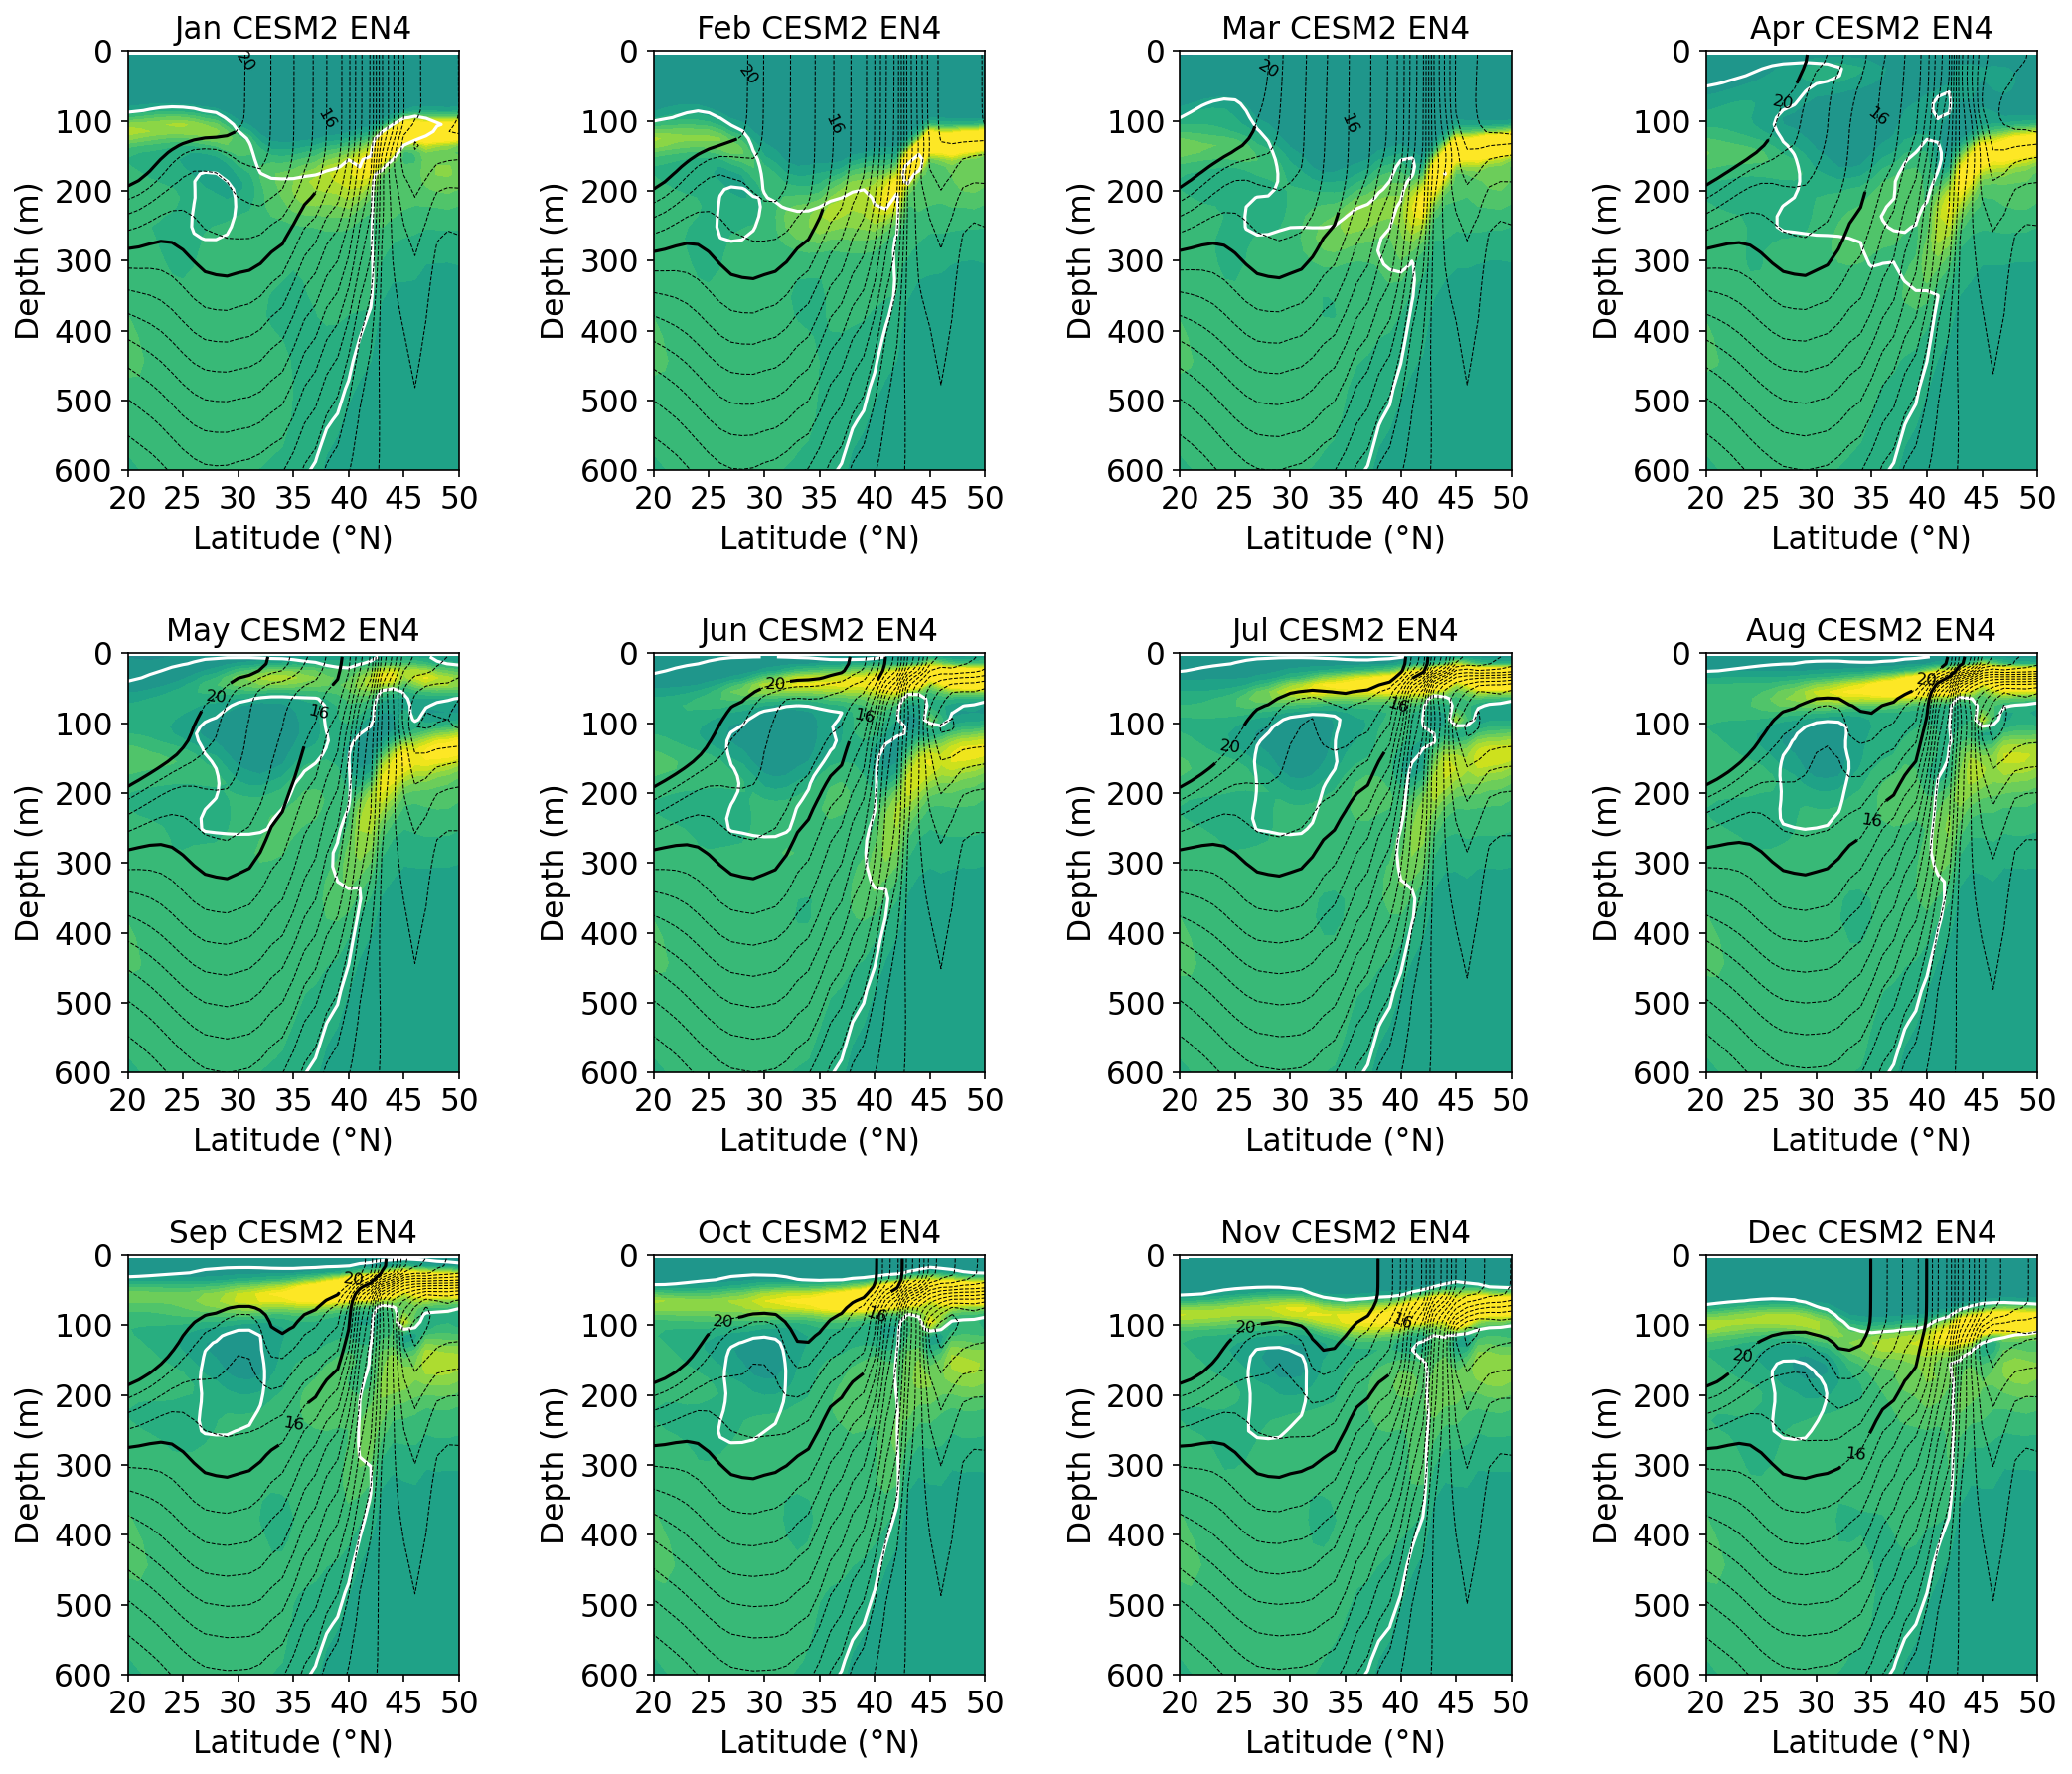

In [256]:
fig = plt.figure(figsize=(14,12))
gs  = gridspec.GridSpec(nrows=3, ncols=4, height_ratios=[1,1,1], width_ratios=[1,1,1,1])

month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
lev1 = np.arange(-2,2.1,0.2); lev2 = np.arange(0,20.1,1)
####################################################################################################################################################################################
for i in range(12):
    ax = plt.subplot(gs[i]); ax.set_title(month[i]+' CESM2 EN4', loc='center', fontsize=15)
    cf1 = contour_zm2(clim_ASM_EN4_E01_DGRAD_ALT_CO2[i], clim_ASM_EN4_E01_TZM_KOE[i], clim_ASM_EN4_E01_TGRAD_KOE[i])

plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

In [146]:
clim_OBS_EN4_TEMP, anom_OBS_EN4_TEMP = calc_anomaly(OBS_EN4_TEMP)
clim_OBS_EN4_TZM_KOE   = clim_OBS_EN4_TEMP.sel(lat=slice(20,50),lon=slice(150,151)).mean(dim=['lon'])
clim_OBS_EN4_TGRAD_KOE = clim_OBS_EN4_TZM_KOE.differentiate(coord='depth')*-10.

clim_ASM_EN4_E01_TEMP, anom_ASM_EN4_E01_TEMP = calc_anomaly(ASM_EN4_E01_TEMP)
clim_ASM_EN4_E01_TZM_KOE   = clim_ASM_EN4_E01_TEMP.sel(lat=slice(20,50),lon=slice(150,151)).mean(dim=['lon'])
clim_ASM_EN4_E01_TGRAD_KOE = clim_ASM_EN4_E01_TZM_KOE.differentiate(coord='depth')*-10.

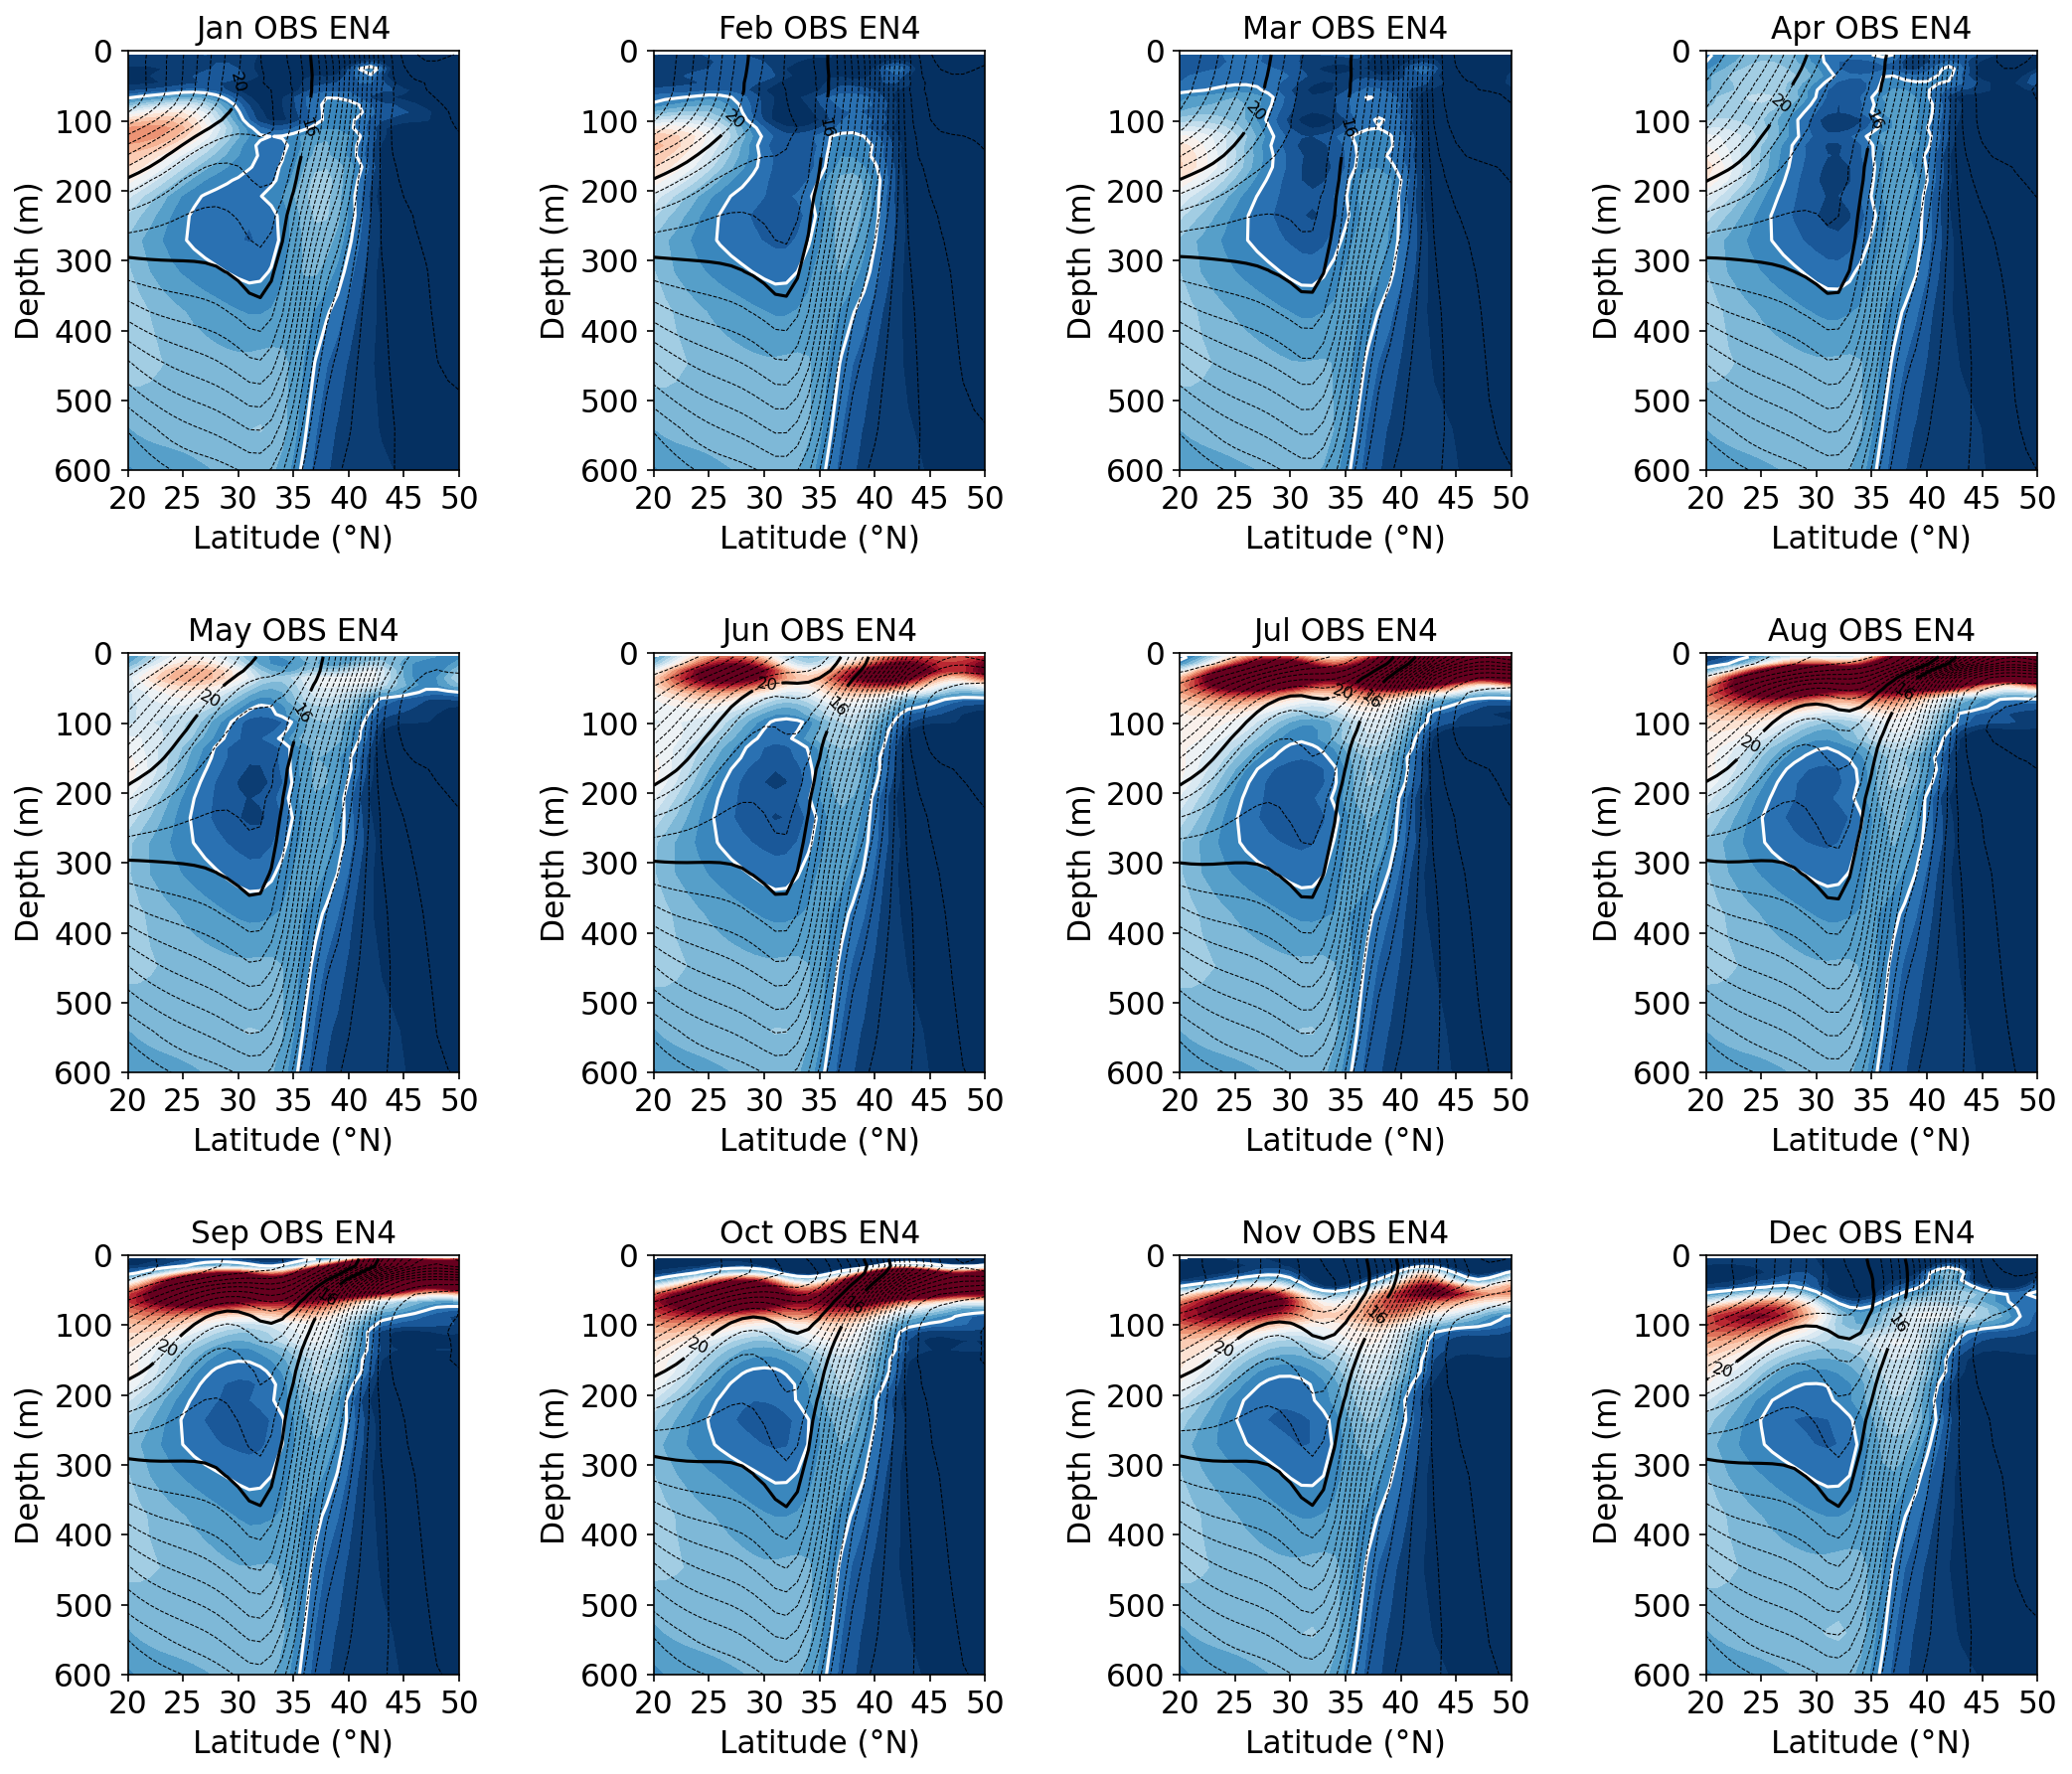

In [147]:
fig = plt.figure(figsize=(14,12))
gs  = gridspec.GridSpec(nrows=3, ncols=4, height_ratios=[1,1,1], width_ratios=[1,1,1,1])

month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
lev1 = np.arange(0,1.01,0.05); lev2 = np.arange(0,30.1,1)
####################################################################################################################################################################################
for i in range(12):
    ax = plt.subplot(gs[i]); ax.set_title(month[i]+' OBS EN4', loc='center', fontsize=15)
    cf1 = contour_zm(clim_OBS_EN4_TGRAD_KOE[i], clim_OBS_EN4_TZM_KOE[i])
    #ax.axvline(x=28, c='r'); ax.axvline(x=36, c='r')

plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

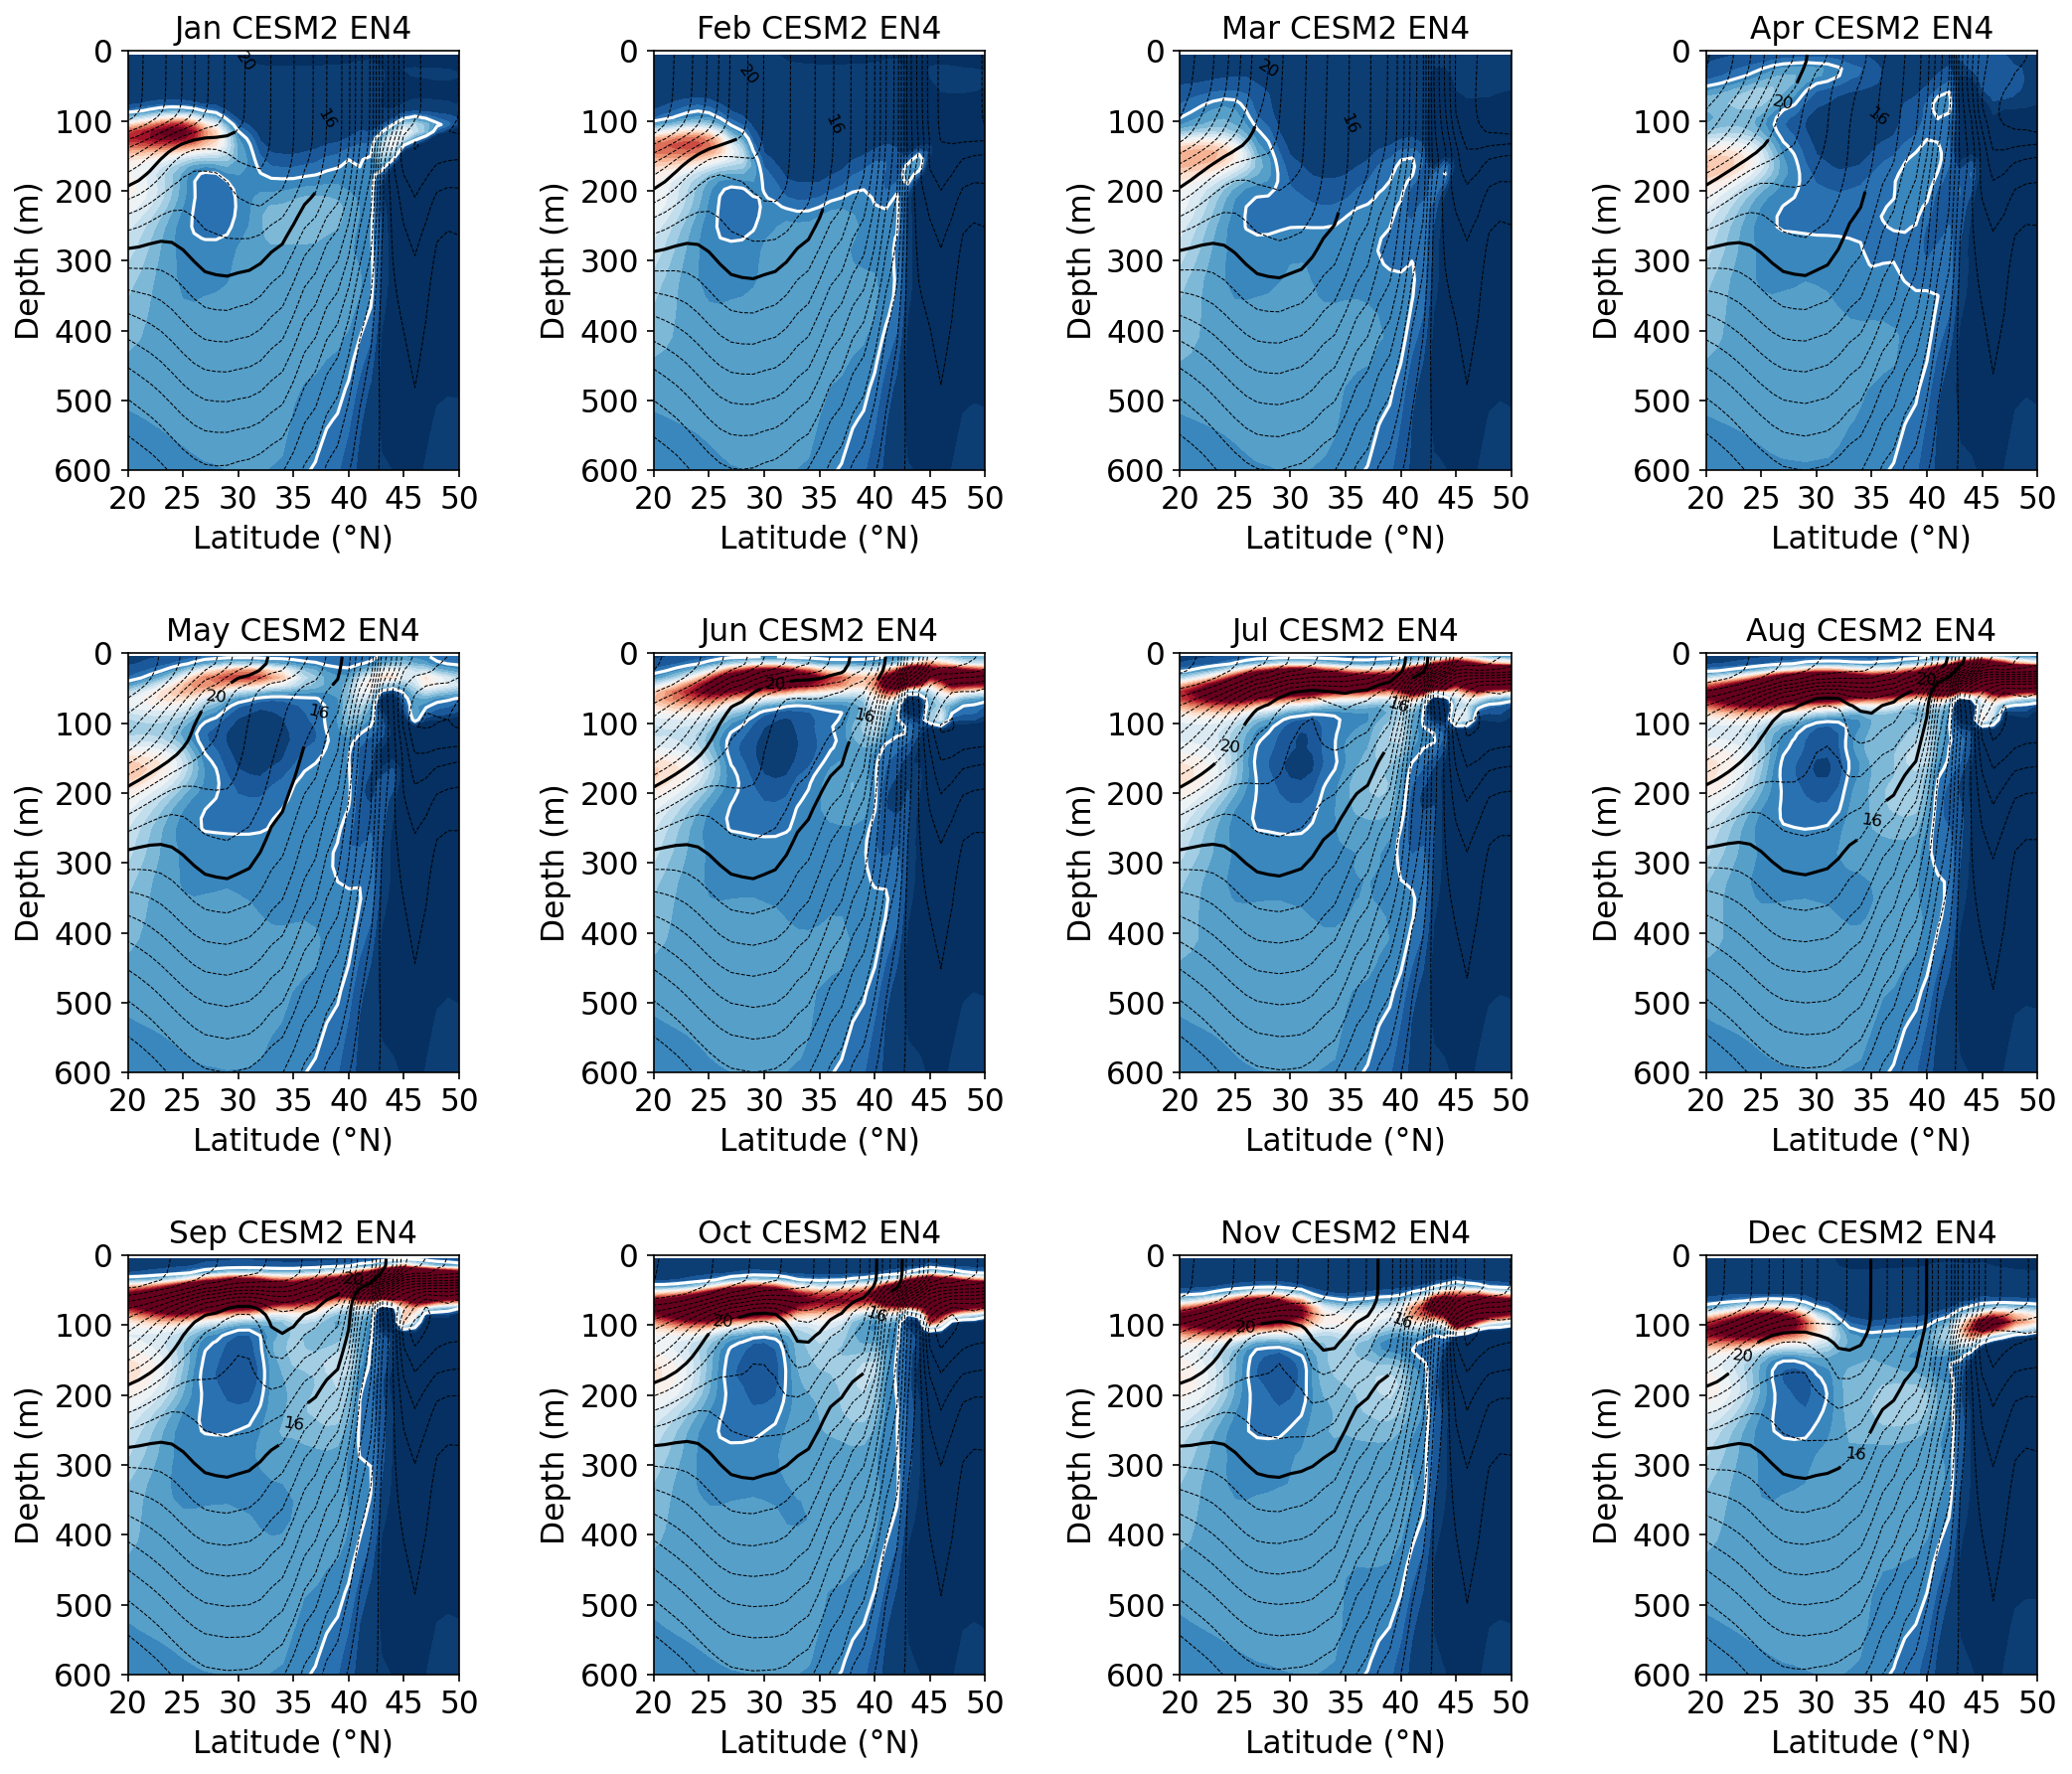

In [148]:
fig = plt.figure(figsize=(14,12))
gs  = gridspec.GridSpec(nrows=3, ncols=4, height_ratios=[1,1,1], width_ratios=[1,1,1,1])

month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
lev1 = np.arange(0,1.01,0.05); lev2 = np.arange(0,30.1,1)
####################################################################################################################################################################################
for i in range(12):
    ax = plt.subplot(gs[i]); ax.set_title(month[i]+' CESM2 EN4', loc='center', fontsize=15)
    cf1 = contour_zm(clim_ASM_EN4_E01_TGRAD_KOE[i], clim_ASM_EN4_E01_TZM_KOE[i])

plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

In [149]:
data1 = season(anom_OBS_EN4_STMWV, [2,3,4]).values;              data2 = season(anom_OBS_IAP_STMWV, [2,3,4]).values
data3 = season(anom_ASM_EN4_STMWV.mean(axis=0), [2,3,4]).values; data4 = season(anom_ASM_PD7_STMWV.mean(axis=0), [2,3,4]).values

print(np.corrcoef(data1,data3)[0][1], np.corrcoef(data1,data4)[0][1])
print(np.corrcoef(data2,data3)[0][1], np.corrcoef(data2,data4)[0][1])

0.8288625004707324 0.7232751509507016
0.6123690679120798 0.7208698376881202
